In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks
import os

In [2]:
archivo = fits.open('Medias-Desviacion279.fits')
archivo.info()

Filename: Medias-Desviacion279.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  MEDIAS        1 ImageHDU         7   (1280954,)   float64   
  2  MAD           1 ImageHDU         7   (1280954,)   float64   
  3  KS_NSAT       1 ImageHDU         8   (68, 1223069)   float64   
  4  EKS_NSAT      1 ImageHDU         8   (68, 1223069)   float64   
  5  MEDIASNS      1 ImageHDU         7   (1223069,)   float64   
  6  MADNS         1 ImageHDU         7   (1223069,)   float64   
  7  Q3_EKS        1 ImageHDU         8   (68, 956867)   float64   
  8  Q3_KS         1 ImageHDU         8   (68, 956867)   float64   
  9  EQ3_EKS       1 ImageHDU         8   (68, 956867)   float64   
 10  D3_KS         1 ImageHDU         8   (68, 306755)   float64   
 11  ED3_EKS       1 ImageHDU         8   (68, 306755)   float64   


In [3]:
series_ks_n_filtrado, errores_ks_n_filtrado= archivo[10].data, archivo[11].data

def seleccionar_subarrays_aleatorios(s, e, cantidad):
    indices_aleatorios = random.sample(range(len(s)), cantidad)
    ks_aleatorios = [s[i] for i in indices_aleatorios]
    errores_aleatorios = [e[i] for i in indices_aleatorios]
    return ks_aleatorios, errores_aleatorios

cantidad_subarrays = 100000
ks_aleatorios, errores_aleatorios = seleccionar_subarrays_aleatorios(series_ks_n_filtrado, errores_ks_n_filtrado, cantidad_subarrays)
print(len(ks_aleatorios))
print(len(errores_aleatorios))


100000
100000


In [8]:
ks_aleatorios, errores_aleatorios= np.array(ks_aleatorios), np.array(errores_aleatorios)
# Crear un objeto HDU (Header Data Unit) de tipo ImageHDU
hdu = fits.ImageHDU(ks_aleatorios, name='ks_ale')

# Crear un objeto HDUList que contiene el HDU
hdul = fits.HDUList([fits.PrimaryHDU(), hdu])

# Especificar el nombre del archivo FITS
nombre_archivo = 'Varibales_2b279.fits'

# Guardar el archivo FITS
hdul.writeto(nombre_archivo, overwrite=True)

# Imprimir un mensaje de confirmación
print(f"Archivo FITS creado {nombre_archivo}")

Archivo FITS creado Varibales_2b279.fits


In [9]:
n_archivo='Varibales_2b279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(errores_aleatorios, name='eks_ale')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {n_archivo}")

Nuevo HDU agregado al archivo FITS: Varibales_2b279.fits


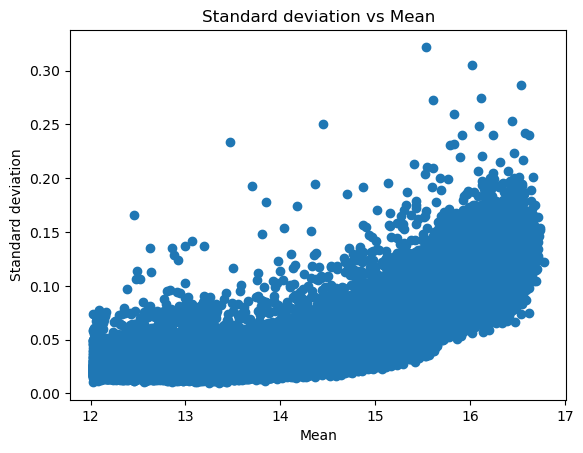

In [10]:
# Función para calcular el promedio excluyendo los NaN
def mean_without_nan(subarray):
    valid_values = [value for value in subarray if not np.isnan(value)]
    return np.mean(valid_values) if valid_values else np.nan

# Función para calcular la desviación estándar excluyendo los NaN
def std_without_nan(subarray):
    valid_values = [value for value in subarray if not np.isnan(value)]
    return np.std(valid_values) if valid_values else np.nan

# Calcula el promedio y la desviación estándar para cada subarray en ks_aleatorios
means = [mean_without_nan(subarray) for subarray in ks_aleatorios]
std_devs = [std_without_nan(subarray) for subarray in ks_aleatorios]

# Grafica la desviación estándar en el eje y y el promedio en el eje x
plt.scatter(means, std_devs)
plt.xlabel('Mean')
plt.ylabel('Standard deviation')
plt.title('Standard deviation vs Mean')
plt.show()

In [13]:
n_archivo='Varibales_2b279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(means, name='means_ale')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {n_archivo}")

Nuevo HDU agregado al archivo FITS: Varibales_2b279.fits


In [14]:
n_archivo='Varibales_2b279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(std_devs, name='std_devs_ale')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {n_archivo}")

Nuevo HDU agregado al archivo FITS: Varibales_2b279.fits


In [15]:
# Definir la función de ajuste
def funcion_ajuste(x, a, b, c):
    return a * x**2 + b * x + c  # Ejemplo de una función cuadrática
# Ajustar la función a los datos
popt, _ = curve_fit(funcion_ajuste, means, std_devs)
# Parámetros óptimos encontrados
a_opt, b_opt, c_opt = popt
# Imprimir la función de ajuste
print(f"Función de ajuste: {a_opt:.2f}x^2 + {b_opt:.2f}x + {c_opt:.2f}")

Función de ajuste: 0.01x^2 + -0.23x + 1.52


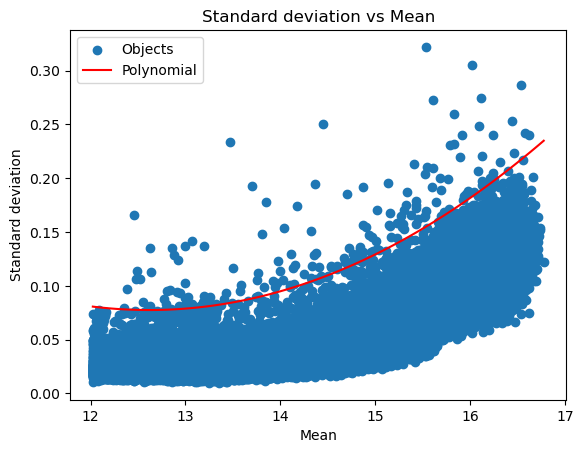

In [19]:
# Plotear los datos y la función de ajuste
plt.scatter(means, std_devs, label='Objects')
x_range = np.linspace(min(means), max(means), 100)
plt.plot(x_range, funcion_ajuste(x_range, *popt+0.0003), color='red', label='Polynomial')
plt.xlabel('Mean')
plt.ylabel('Standard deviation')
plt.title('Standard deviation vs Mean')
plt.legend()
plt.show()

In [17]:
# Convertir means a un array de NumPy si no lo es
means = np.array(means)

# Calcular los valores predichos por la función ajustada para todos los elementos de means
predicciones = funcion_ajuste(means, *popt+0.0003)

# Encontrar las posiciones donde std_devs está por encima de las predicciones
posiciones_por_encima = np.where(std_devs > predicciones)[0]

# Imprimir las posiciones por encima del ajuste
print(len(posiciones_por_encima))

179


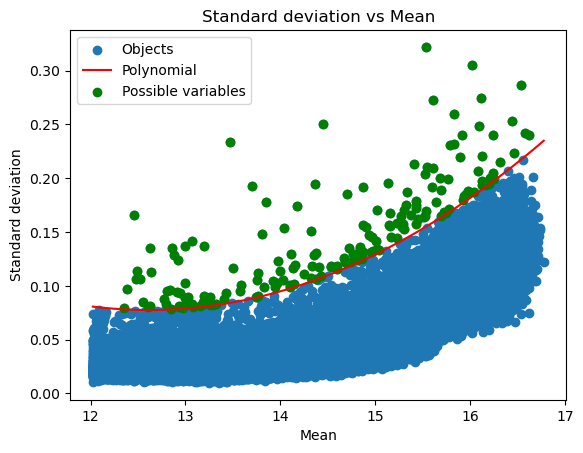

In [20]:
# Convertir means y std_devs a arrays de NumPy si no lo son
means = np.array(means)
std_devs = np.array(std_devs)

# Plotear los datos y la función de ajuste
plt.scatter(means, std_devs, label='Objects')
x_range = np.linspace(min(means), max(means), 100)
plt.plot(x_range, funcion_ajuste(x_range, *popt+0.0003), color='red', label='Polynomial')

# Plotear las posiciones por encima del ajuste cuadrático en otro color
plt.scatter(means[posiciones_por_encima], std_devs[posiciones_por_encima], color='green', label='Possible variables')

plt.xlabel('Mean')
plt.ylabel('Standard deviation')
plt.title('Standard deviation vs Mean')
plt.legend()
plt.show()

In [21]:
# Nuevo array para almacenar la información correspondiente a las posiciones sobre el ajuste
posibles_variables = []
pv_error=[]
# Iterar sobre las posiciones por encima del ajuste
for pos in posiciones_por_encima:
    posibles_variables.append(ks_aleatorios[pos])
    pv_error.append(errores_aleatorios[pos])
# Convertir la lista de subarrays a un array de NumPy
posibles_variables= np.array(posibles_variables)
pv_error=np.array(pv_error)
print(len(posibles_variables))
print(len(pv_error))

179
179


In [22]:
n_archivo='Varibales_2b279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(posibles_variables, name='PV')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {n_archivo}")

Nuevo HDU agregado al archivo FITS: Varibales_2b279.fits


In [23]:
n_archivo='Varibales_2b279.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(pv_error, name='ePV')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {n_archivo}")

Nuevo HDU agregado al archivo FITS: Varibales_2b279.fits


In [2]:
archivo1 = fits.open('TCampo_b279.fits')
archivo= fits.open('Varibales_2b279.fits')
archivo.info()

Filename: Varibales_2b279.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  KS_ALE        1 ImageHDU         8   (68, 100000)   float64   
  2  EKS_ALE       1 ImageHDU         8   (68, 100000)   float64   
  3  MEANS_ALE     1 ImageHDU         7   (100000,)   float64   
  4  STD_DEVS_ALE    1 ImageHDU         7   (100000,)   float64   
  5  PV            1 ImageHDU         8   (68, 179)   float64   
  6  EPV           1 ImageHDU         8   (68, 179)   float64   


In [3]:
HJD=archivo1[1].data
Error=archivo[6].data
Ks=archivo[5].data

In [4]:
def eliminar_nan(error, ks, HJD):
    indices_validos = ~np.isnan(ks)
    error_filtrado = [error[i] for i in range(len(ks)) if indices_validos[i]]
    ks_filtrado = [ks[i] for i in range(len(ks)) if indices_validos[i]]
    HJD_filtrado = [HJD[i] for i in range(len(ks)) if indices_validos[i]]
    return error_filtrado, ks_filtrado, np.round(HJD_filtrado,8)

ks_nan=[]
error_nan=[]
HJD_na=[]
y=0
while y<len(Ks):
    error_filtrado, ks_filtrado, HJD_filtrado = eliminar_nan(Error[y], Ks[y], HJD-2400000)
    ks_nan.append(ks_filtrado)
    error_nan.append(error_filtrado)
    HJD_na.append(HJD_filtrado)
    y+=1
print(error_nan[-1])
print(ks_nan[-1])
print(HJD_na[-1])

[0.024, 0.024, 0.026, 0.024, 0.024, 0.024, 0.024, 0.025, 0.03, 0.027, 0.025, 0.027, 0.027, 0.025, 0.026, 0.024, 0.026, 0.025, 0.03, 0.029, 0.025, 0.026, 0.025, 0.025, 0.029, 0.026, 0.026, 0.028, 0.028, 0.024, 0.026, 0.042, 0.026, 0.026, 0.032, 0.027, 0.028, 0.028, 0.029, 0.03, 0.025, 0.035, 0.028, 0.028, 0.03, 0.027, 0.033, 0.028, 0.029, 0.038, 0.026, 0.029, 0.032, 0.029, 0.062, 0.027, 0.029, 0.032, 0.031, 0.034, 0.03, 0.033, 0.042]
[14.248, 14.147, 14.321, 14.184, 14.196, 14.184, 14.197, 14.247, 14.415, 14.285, 14.249, 14.276, 14.27, 14.217, 14.222, 14.168, 14.266, 14.193, 14.379, 14.356, 14.193, 14.205, 14.167, 14.182, 14.306, 14.228, 14.18, 14.265, 14.224, 14.173, 14.206, 14.674, 14.182, 14.186, 14.409, 14.196, 14.218, 14.191, 14.125, 14.233, 14.169, 14.467, 14.207, 14.232, 14.331, 14.221, 14.446, 14.226, 14.24, 14.493, 14.178, 14.243, 14.239, 14.204, 14.413, 14.132, 14.203, 14.022, 14.067, 14.312, 14.226, 14.135, 14.541]
[55309.7589699  55818.52390016 56160.60001347 56484.58745569


In [28]:
x=0
while x<len(ks_nan):
    serie = ks_nan[x]
    erro = error_nan[x]
    hjd = HJD_na[x]

    # Definir el nombre del archivo de texto
    nombre_archivo = "b279D"+str(x)+".txt"

    with open(nombre_archivo, "w") as archivo:
        for h, s, e in zip(hjd, serie, erro):
            archivo.write("{:<10} {:<10} {:<10}\n".format(h, s, e))
    x+=1
print("hecho")

hecho


In [30]:
y=0
freq=[]
powe=[]
peri=[]
nombre=[]
while y<len(ks_nan):
    S=ks_nan[y]
    Date=HJD_na[y]
    # Calcular el espectro de potencia utilizando Lomb-Scargle
    frequency, power = LombScargle(Date, S).autopower()
    # Encontrar picos en el espectro de potencia
    peaks, _ = find_peaks(power)
    # Obtener los 5 picos más significativos
    sorted_peaks = sorted(peaks, key=lambda x: power[x], reverse=True)[:5]
    frecuencia, potencia= frequency[sorted_peaks], list(power[sorted_peaks])
    max_p=max(potencia)
    r = potencia.index(max_p)
    f=frecuencia[r]
    P=1/f
    nombre.append("Datosb279"+str(y)+".txt")
    freq.append(f)
    powe.append(max_p)
    peri.append(P)
    y+=1

In [31]:
# Ordenar las listas basadas en la lista powe
sorted_data = sorted(zip(powe, freq, peri, nombre), reverse=True)
# Desempaquetar las listas ordenadas
powe, freq, peri, nombre = zip(*sorted_data)
# Nombre del archivo de texto
nombre_archivo = "2B279.txt"
# Guardar en archivo de texto
with open(nombre_archivo, "w") as archivo:
    for n in nombre:
        archivo.write(n + "\n") 

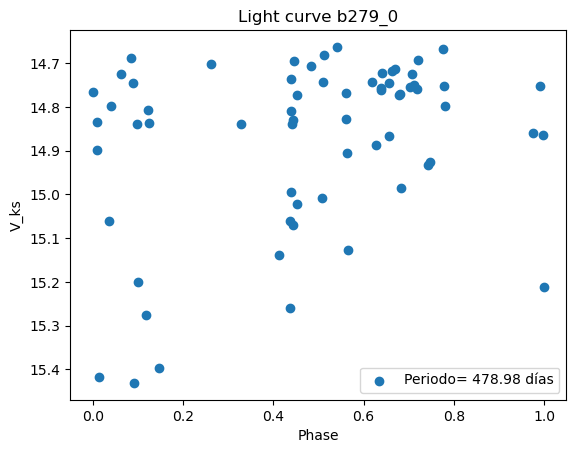

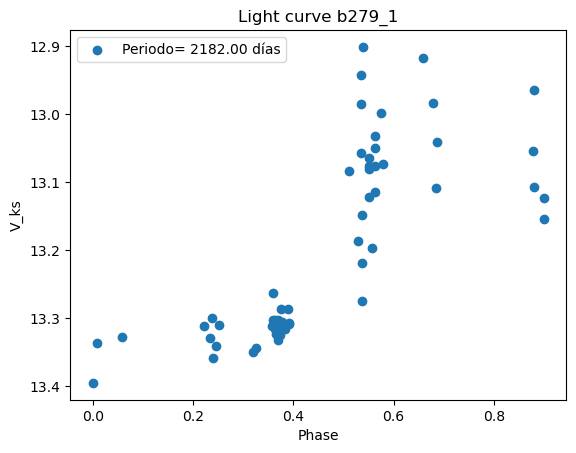

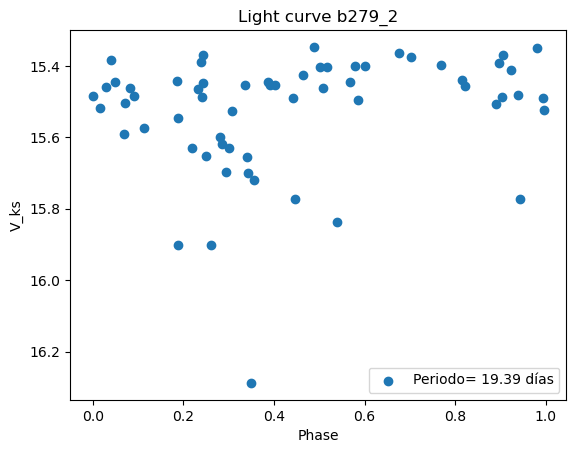

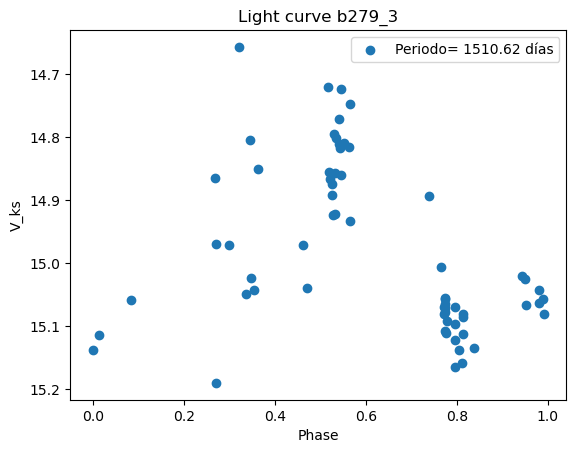

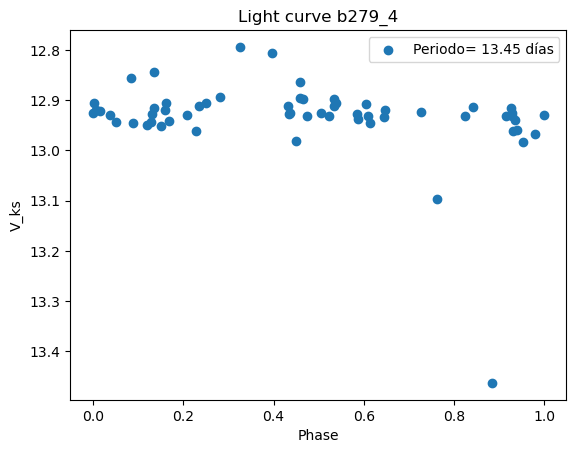

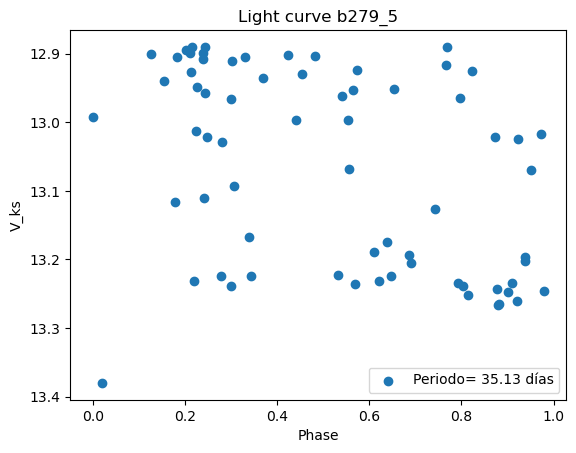

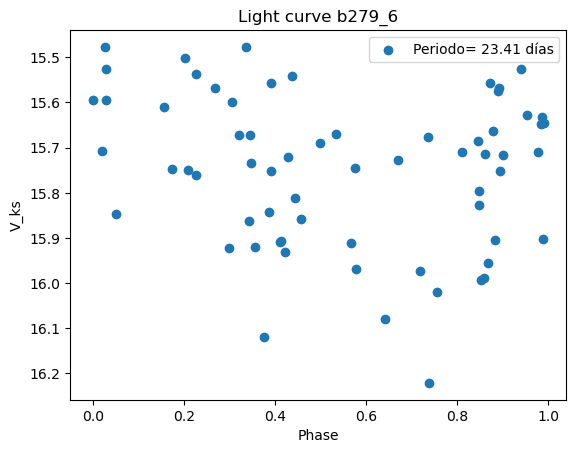

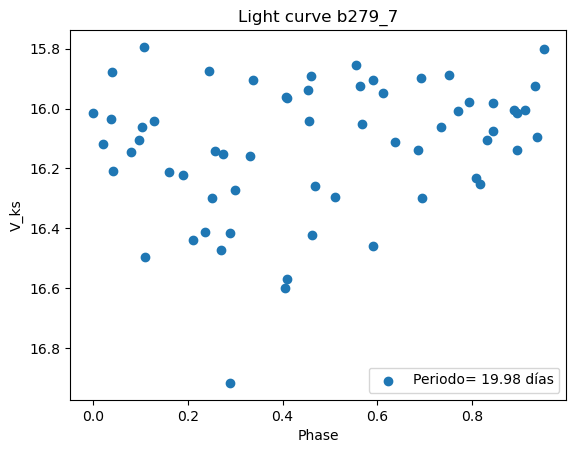

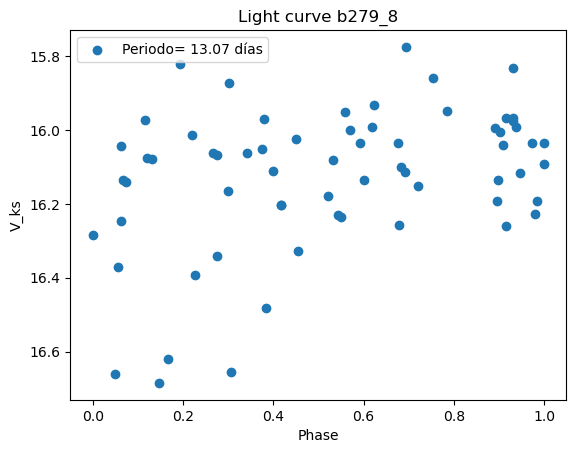

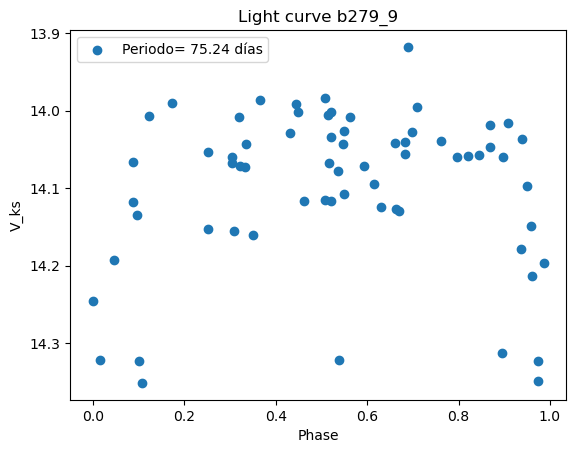

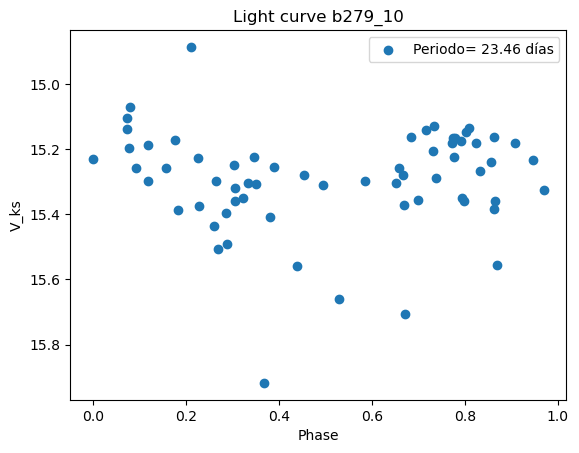

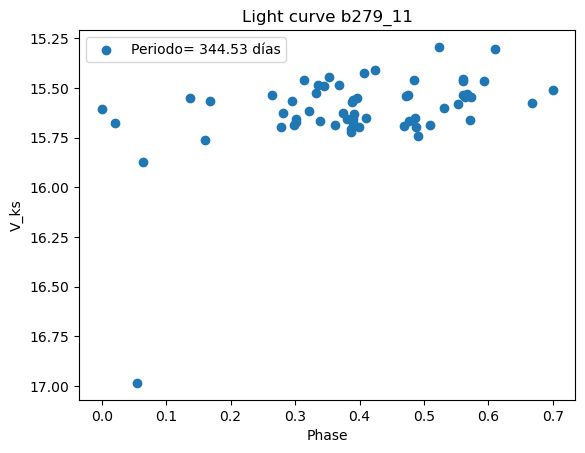

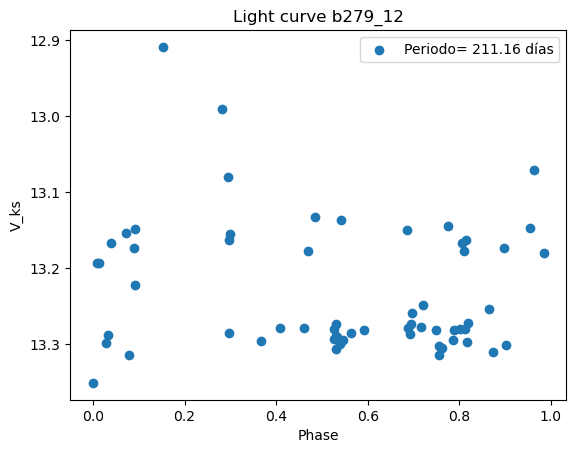

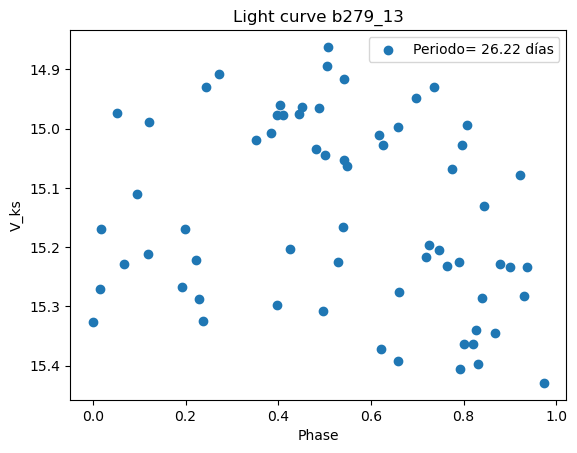

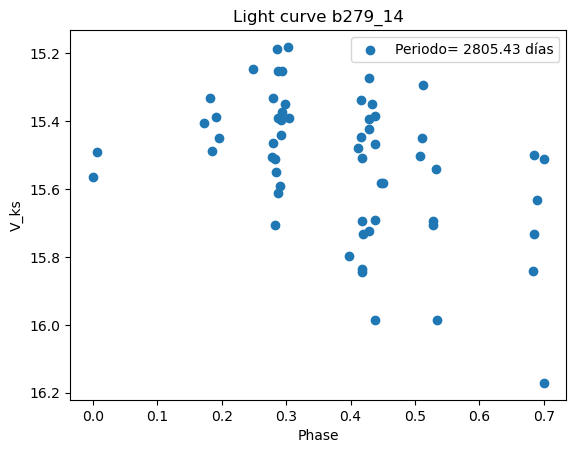

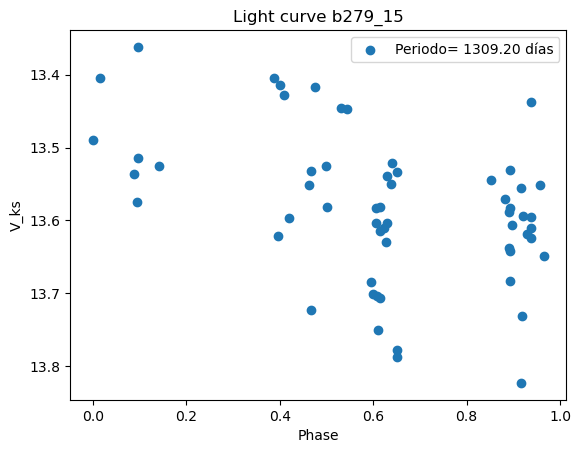

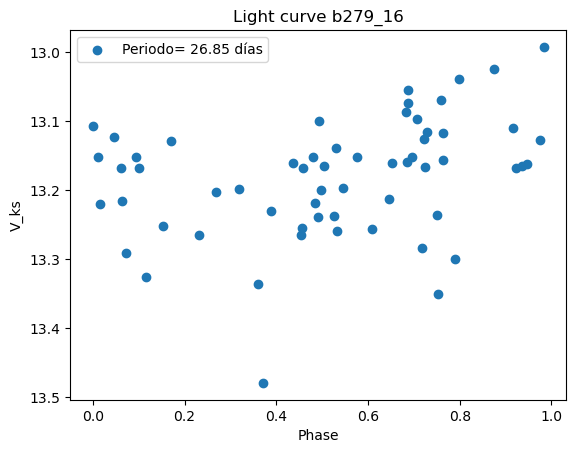

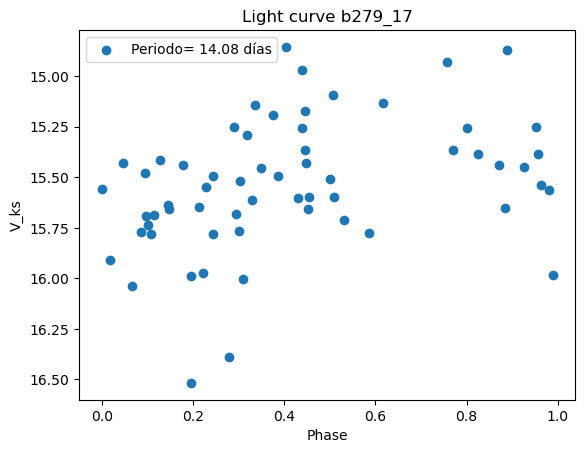

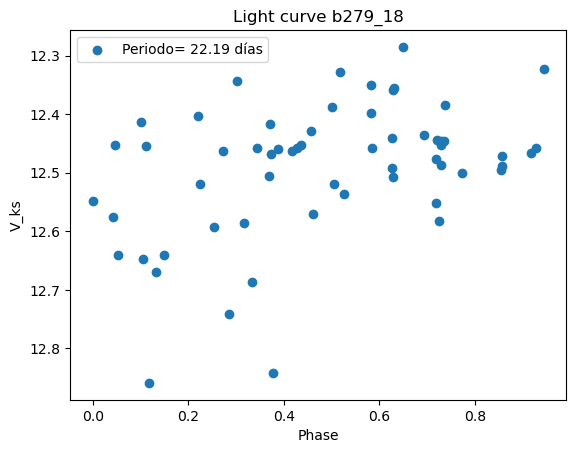

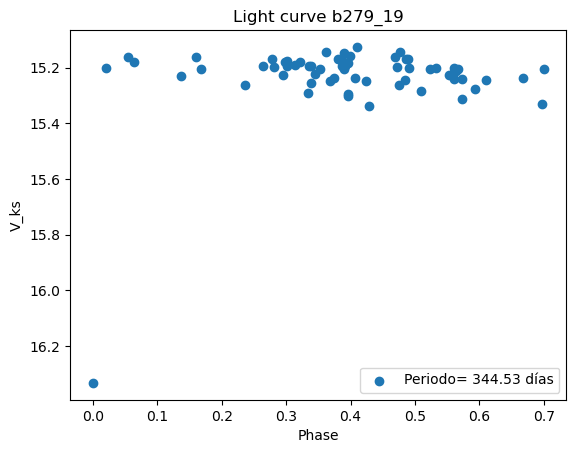

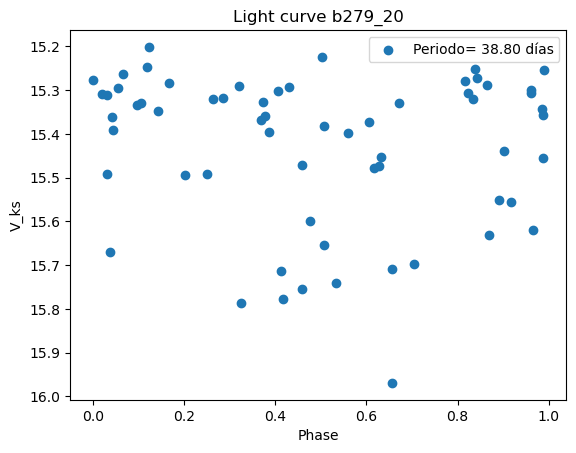

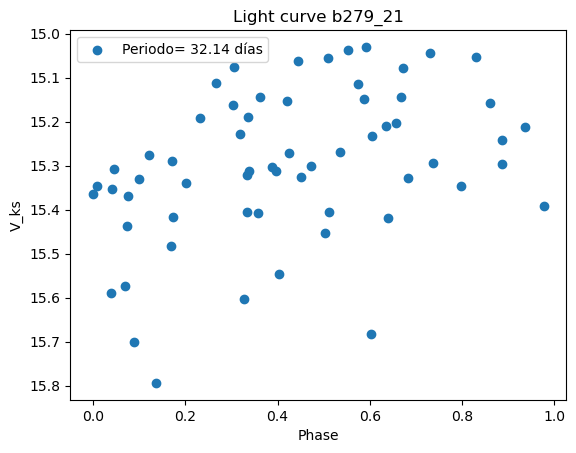

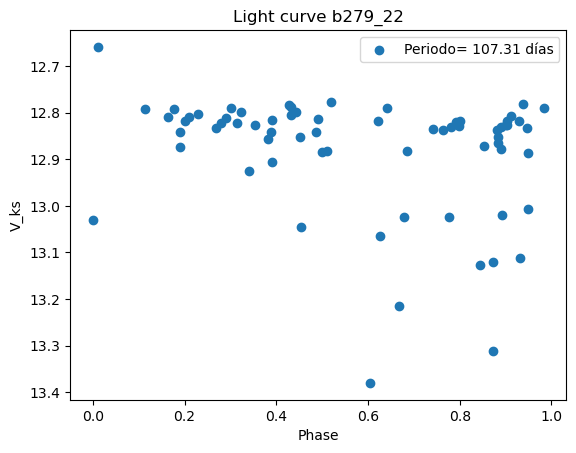

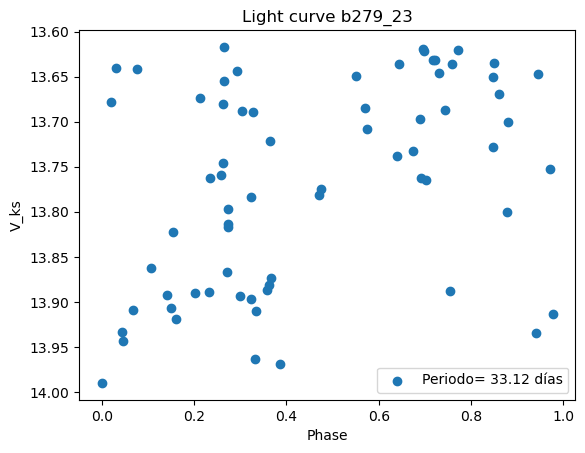

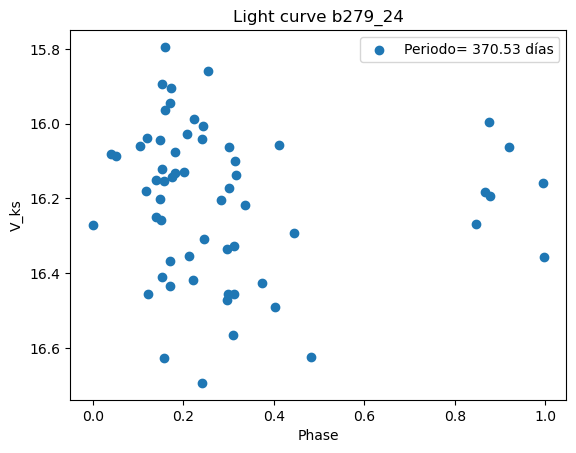

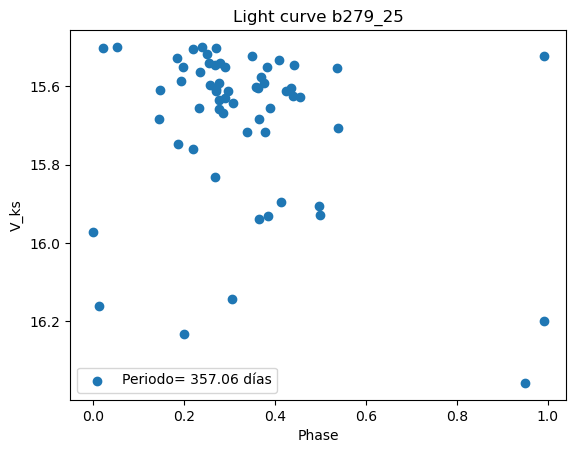

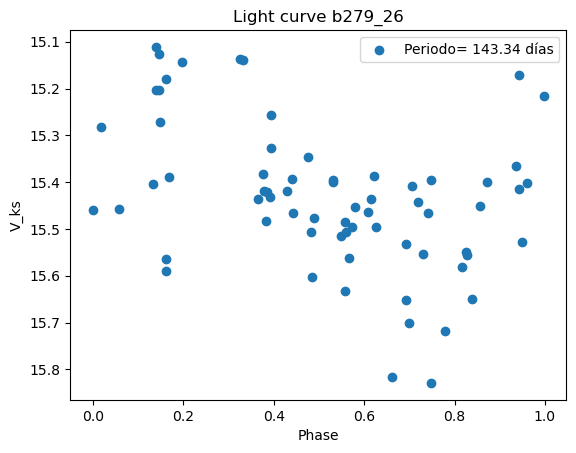

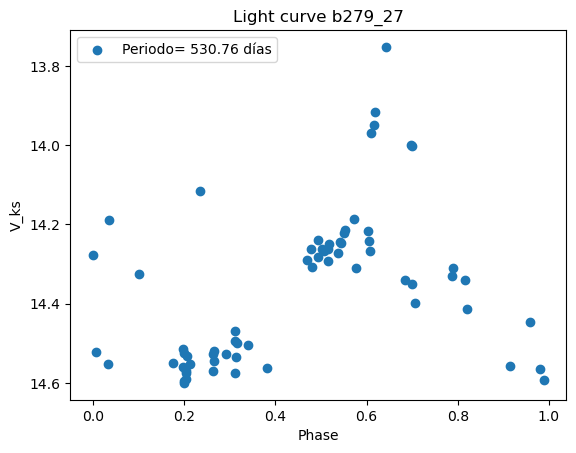

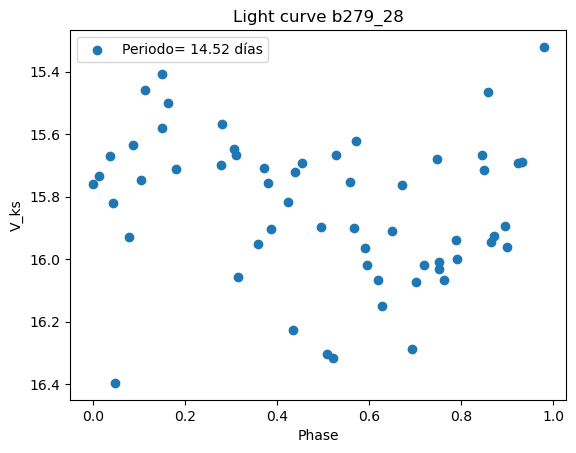

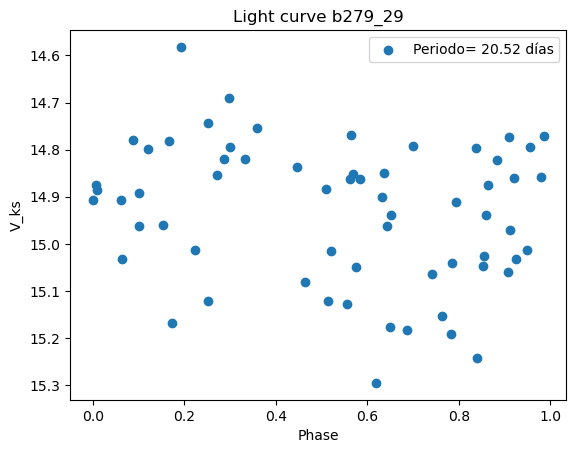

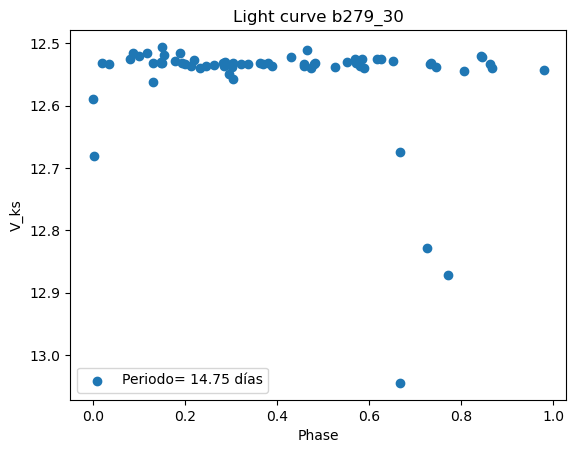

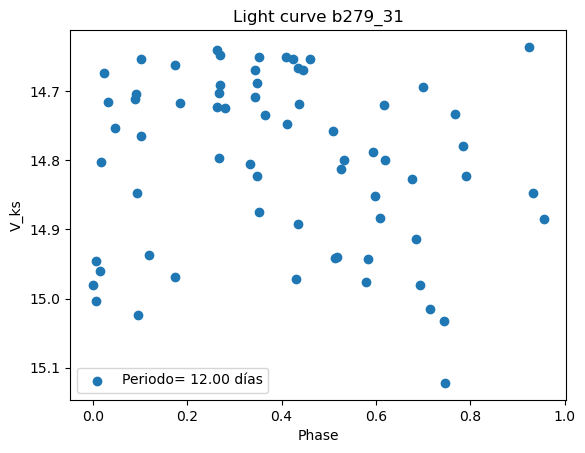

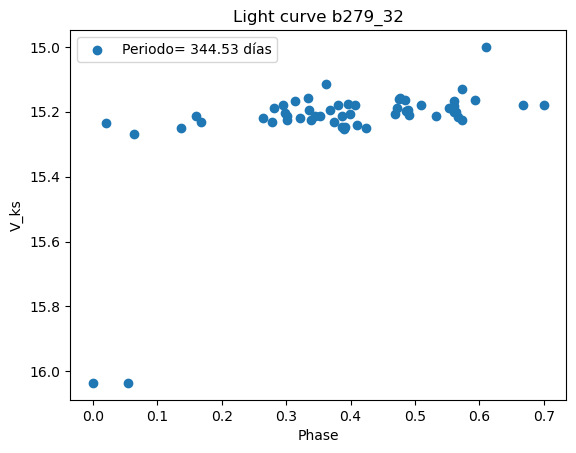

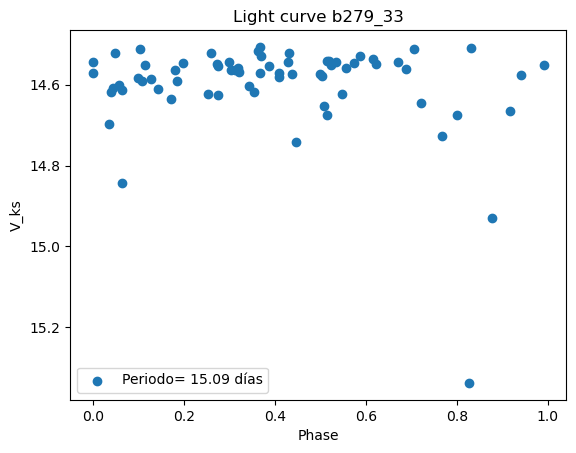

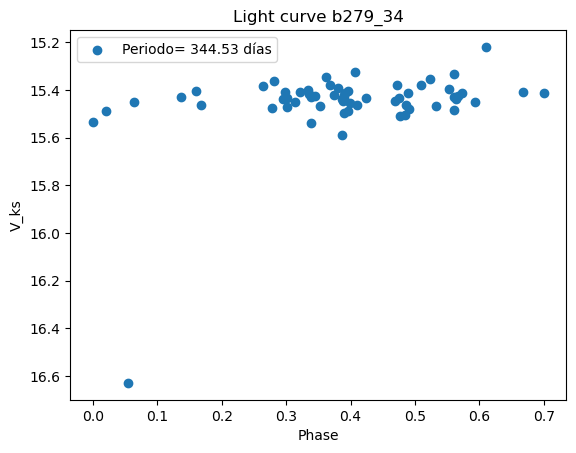

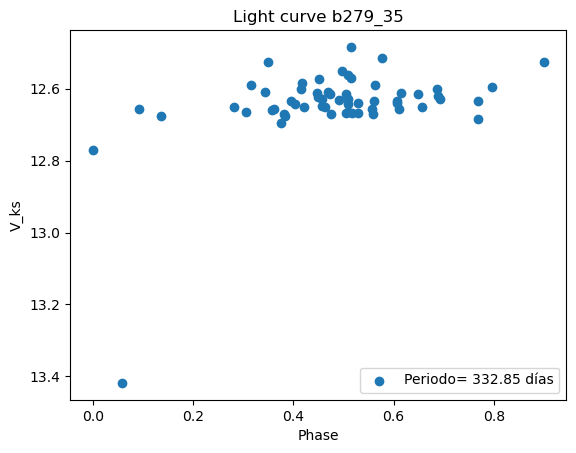

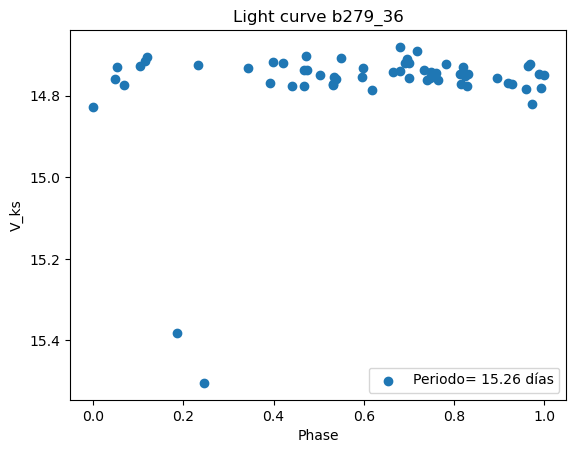

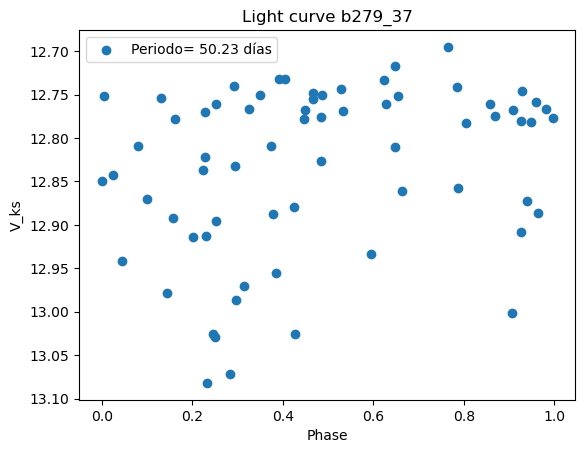

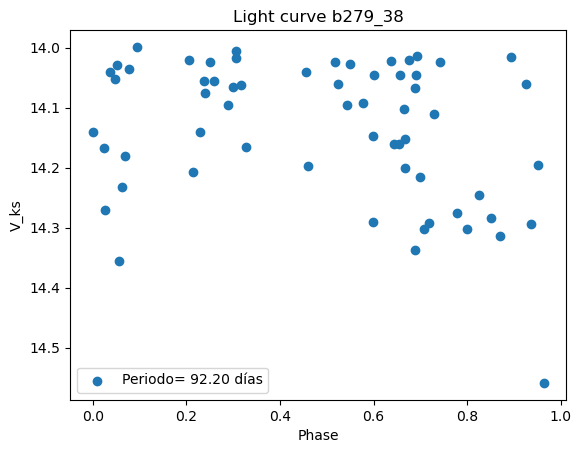

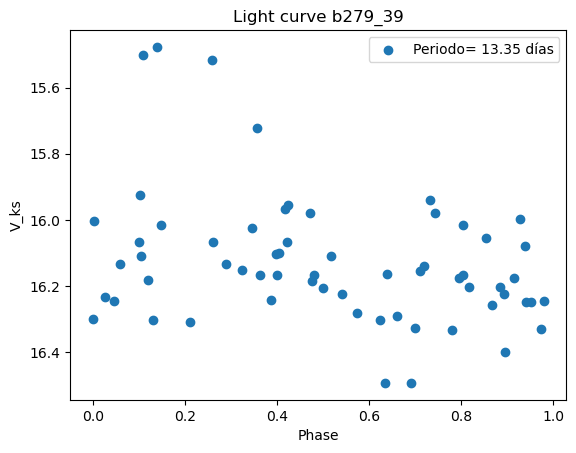

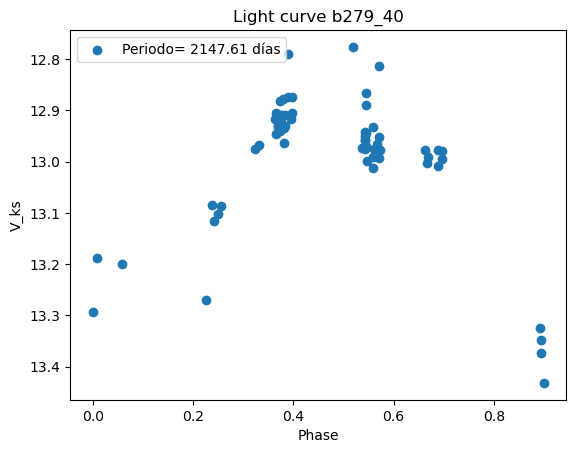

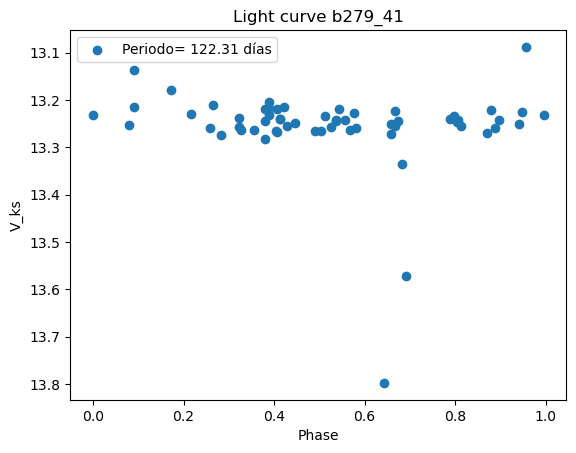

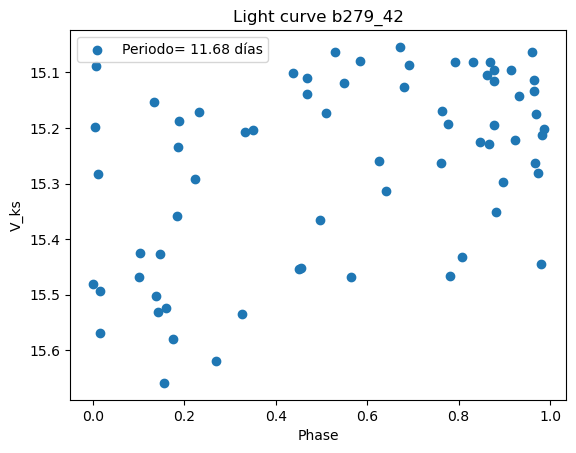

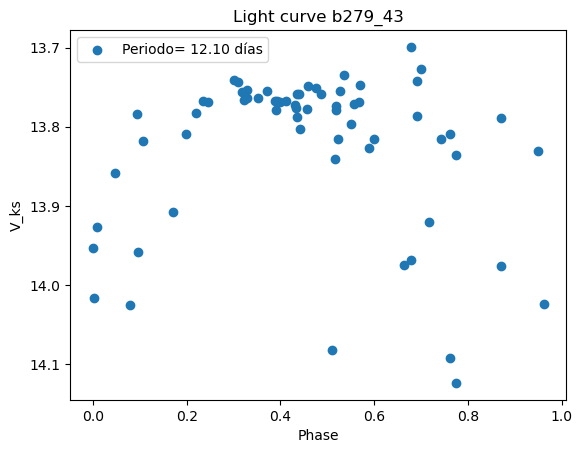

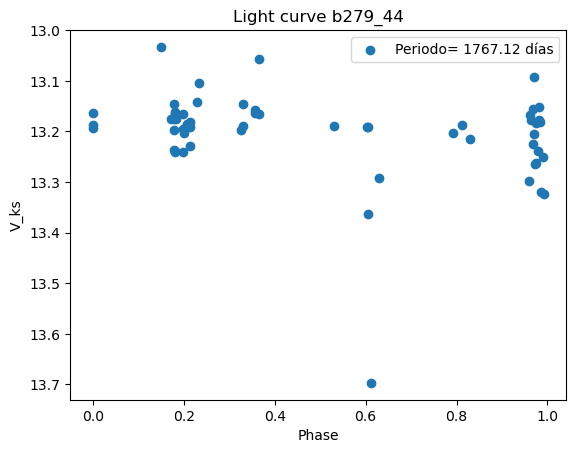

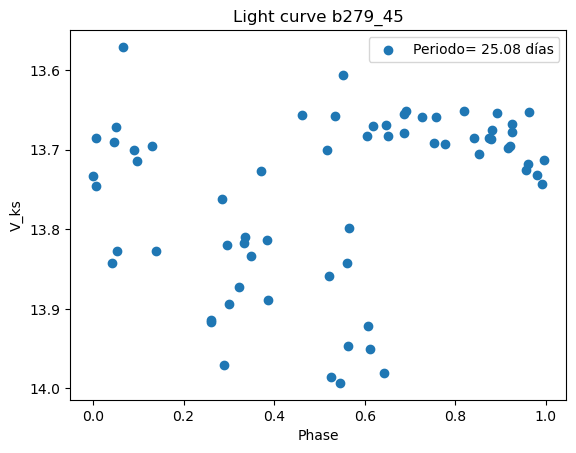

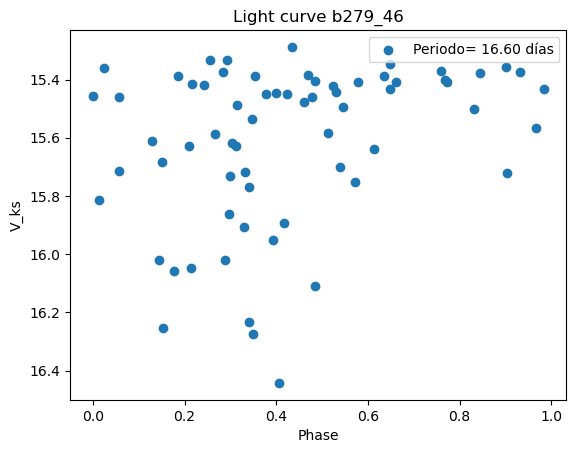

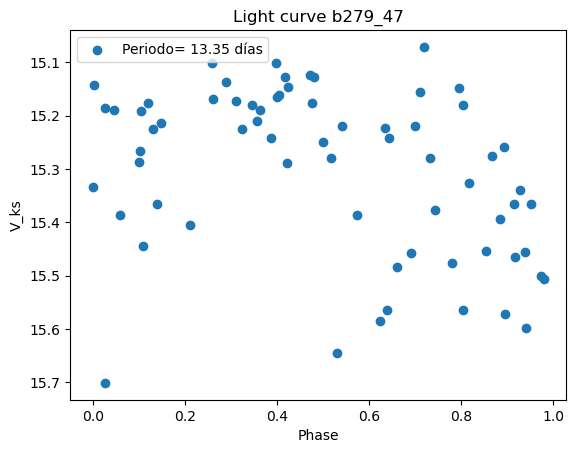

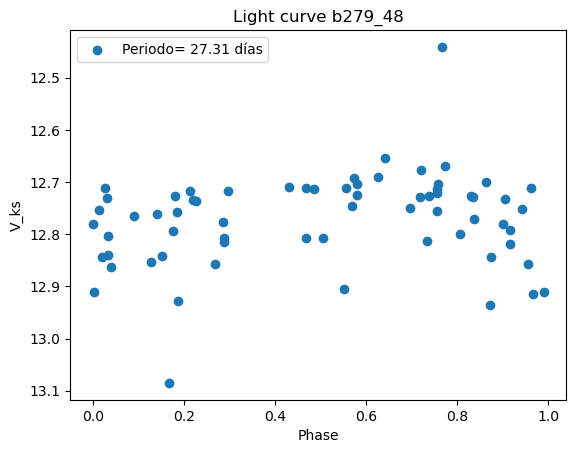

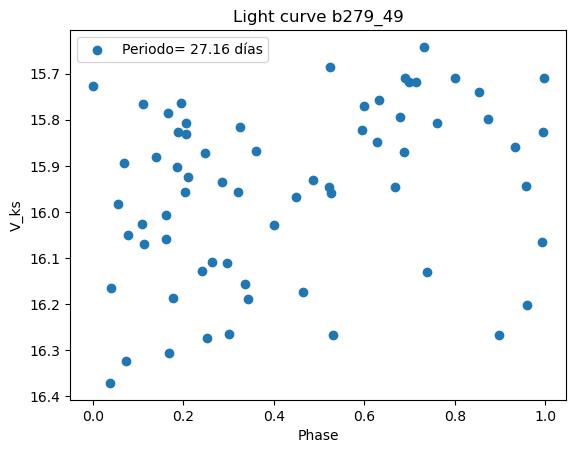

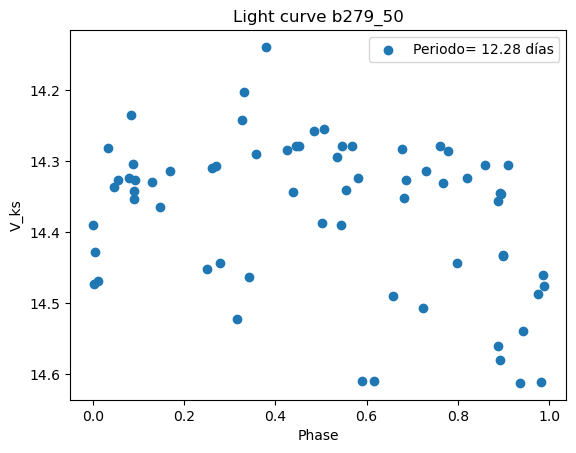

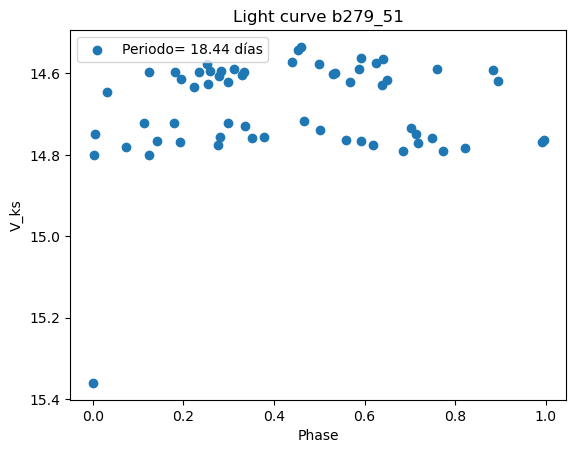

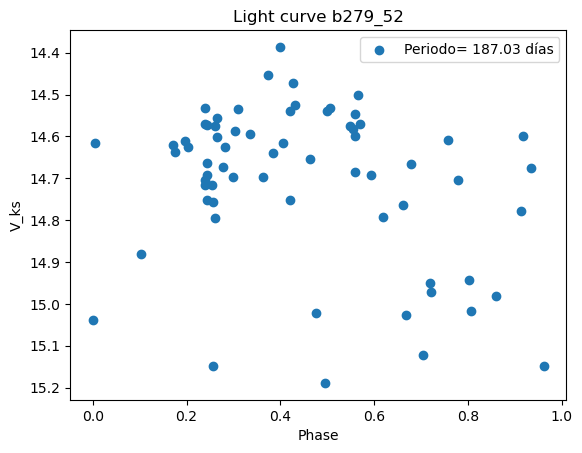

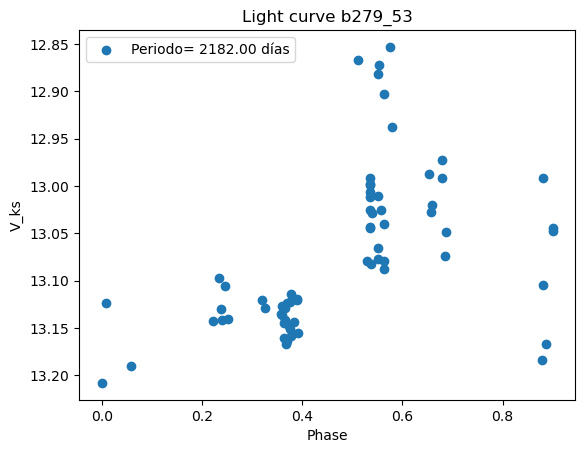

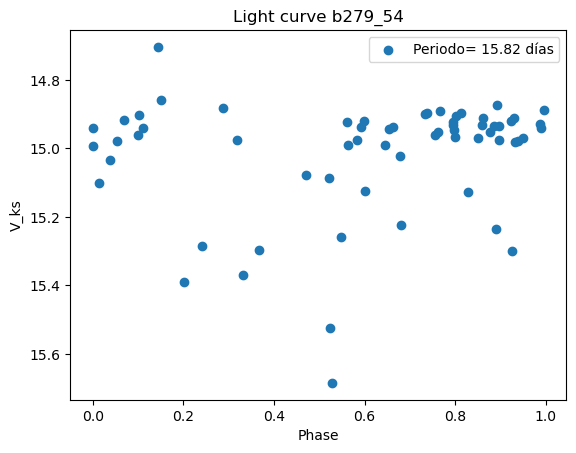

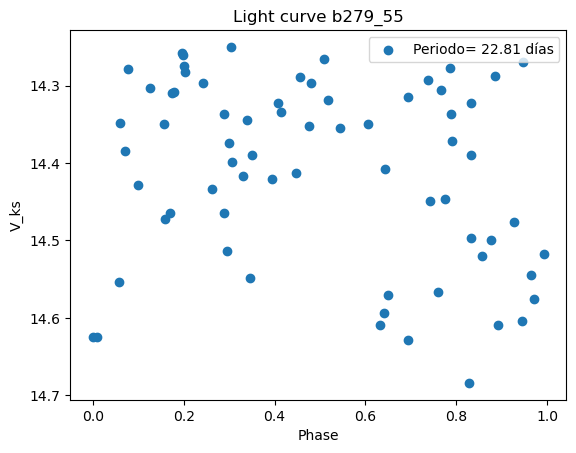

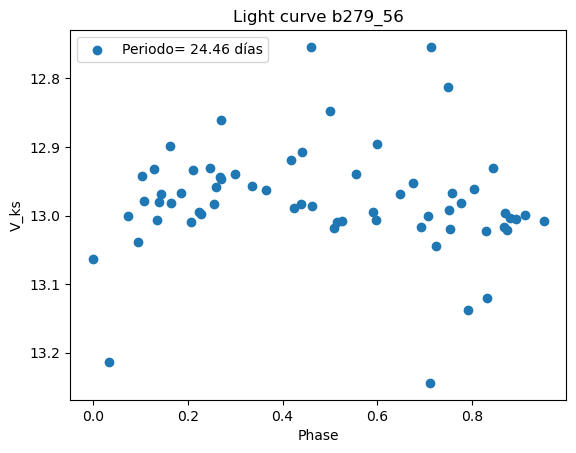

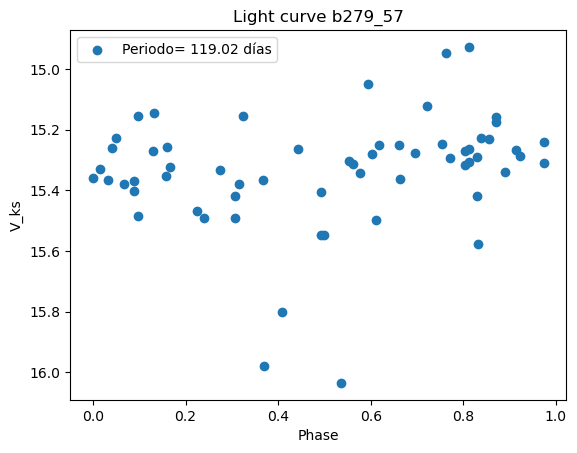

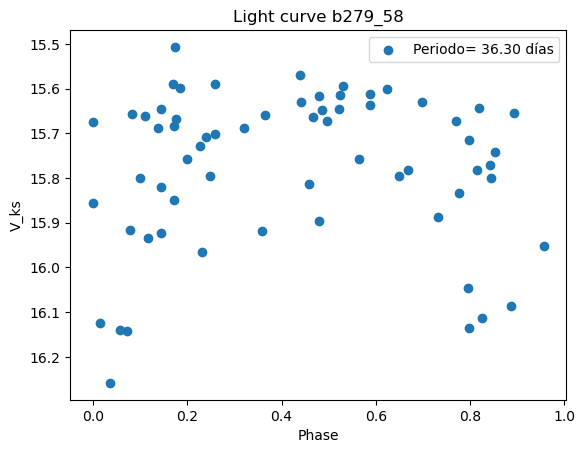

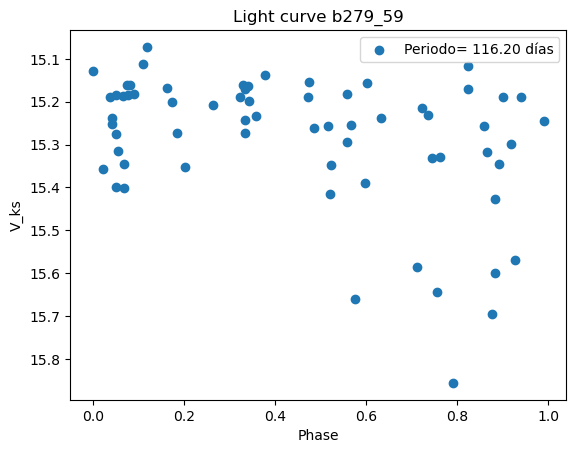

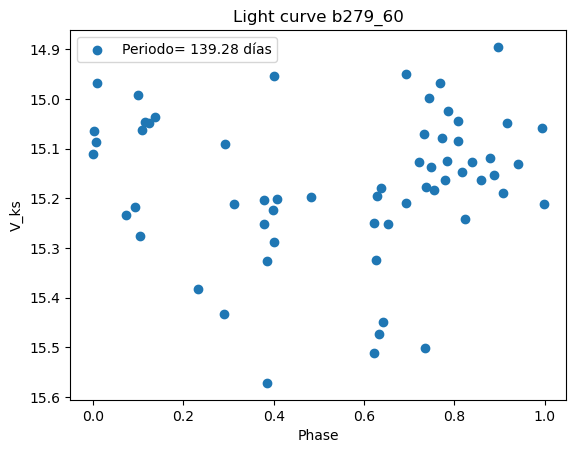

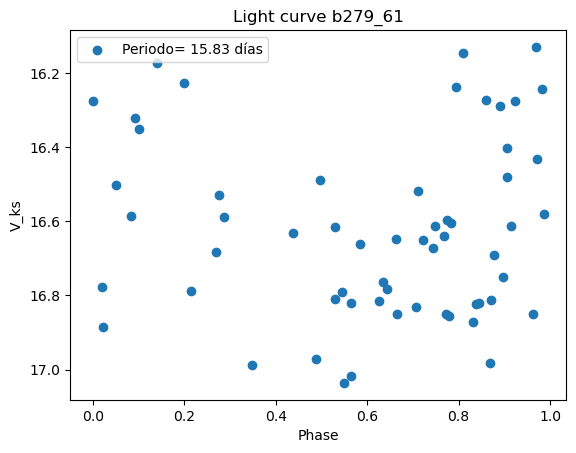

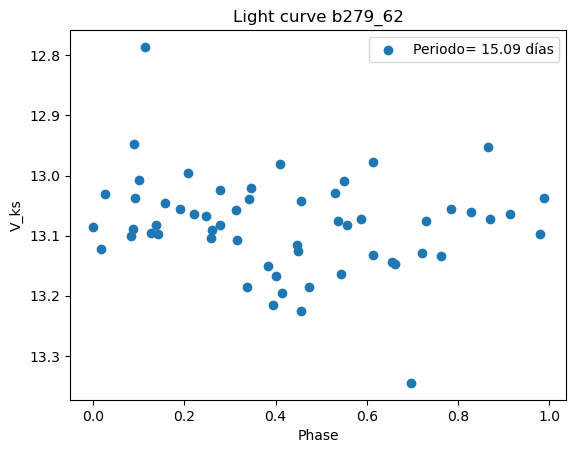

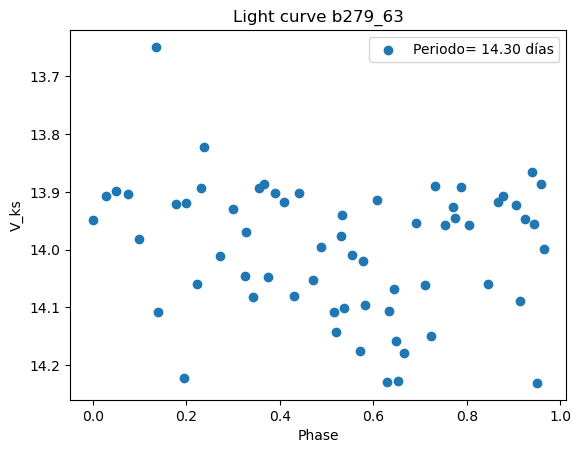

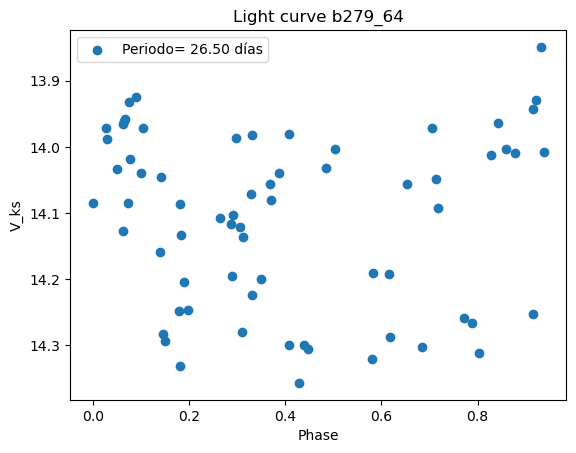

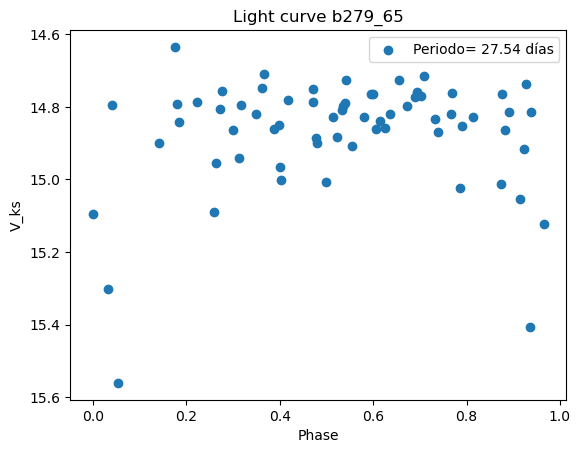

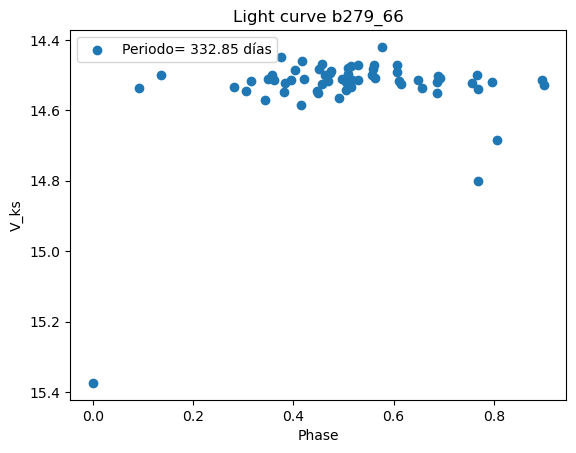

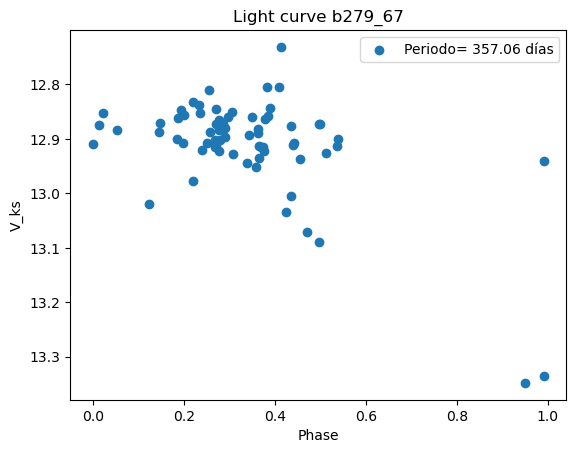

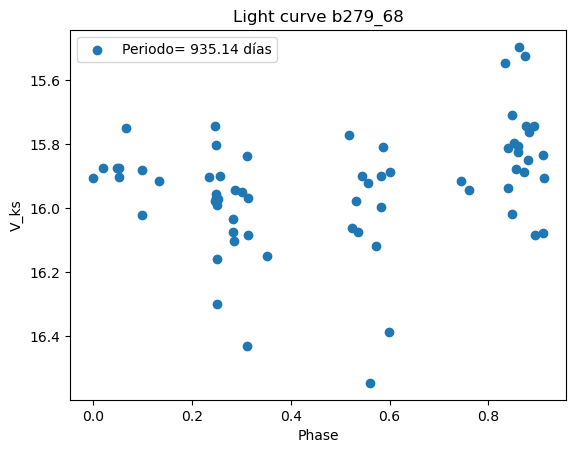

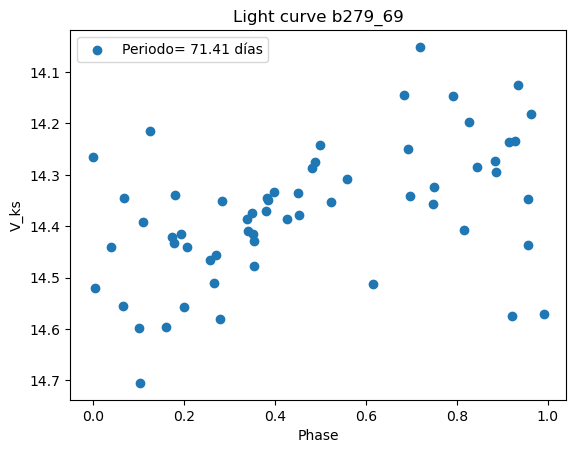

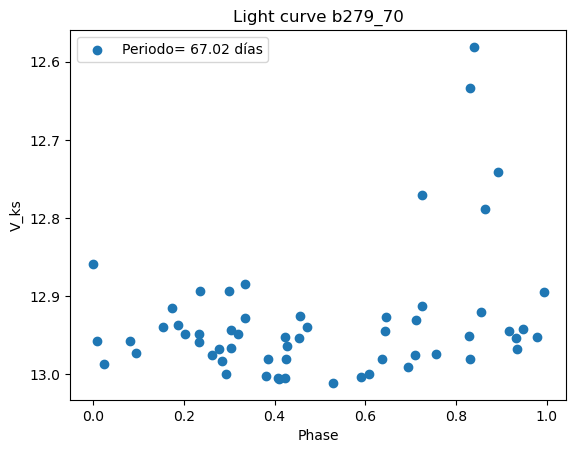

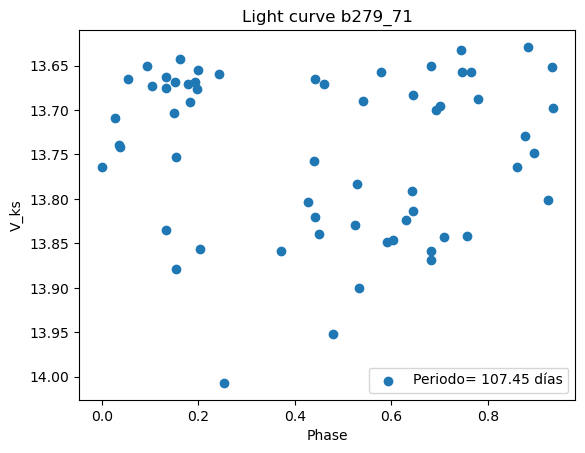

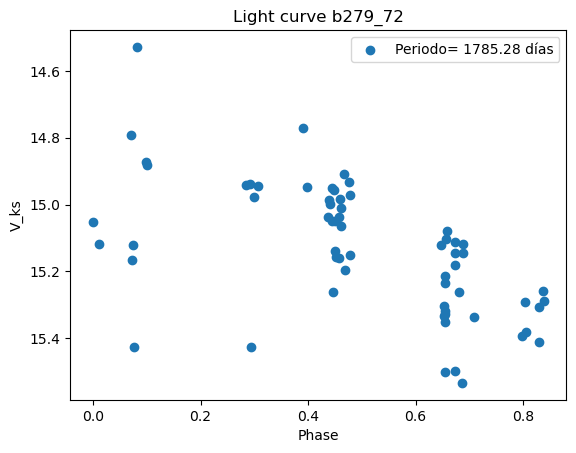

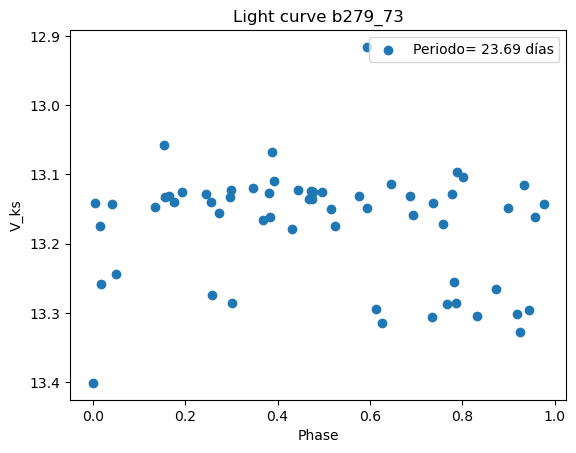

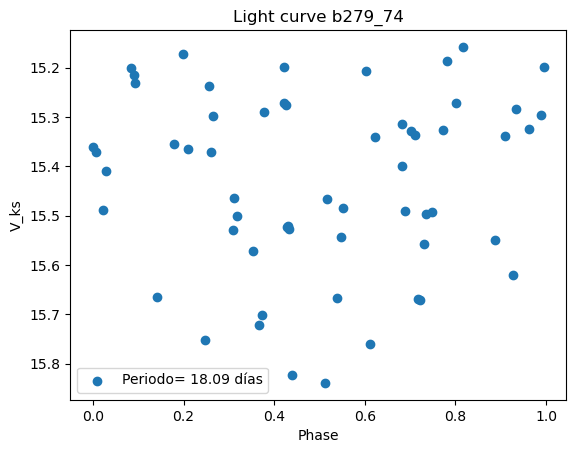

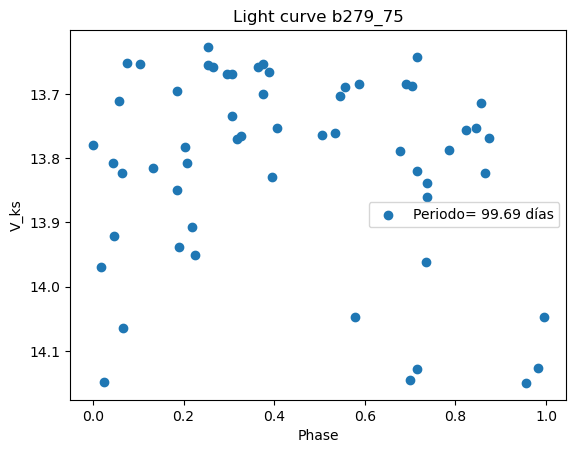

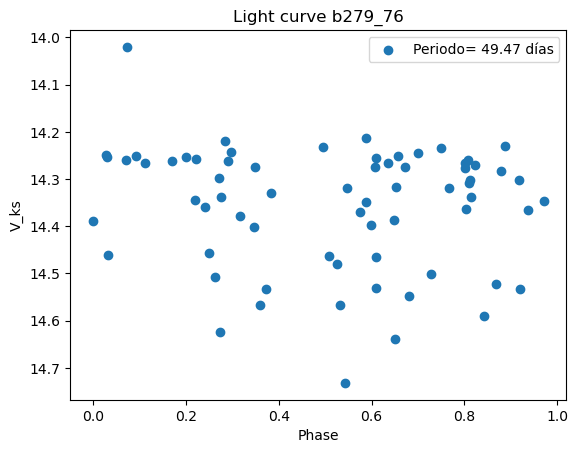

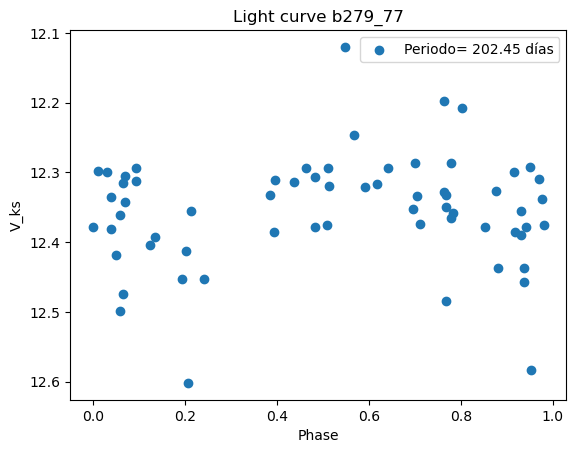

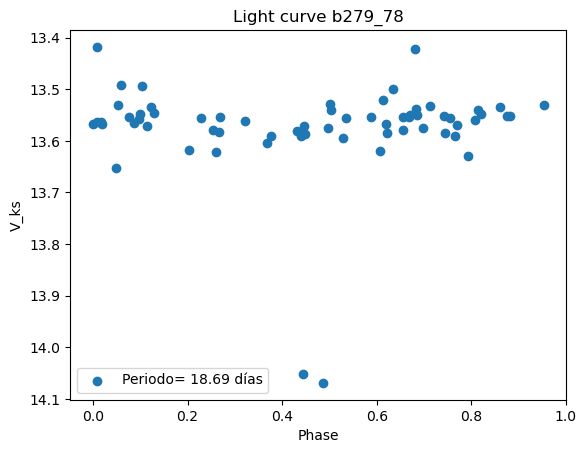

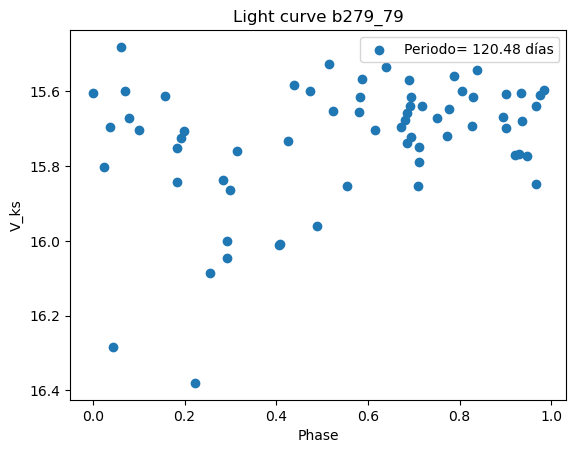

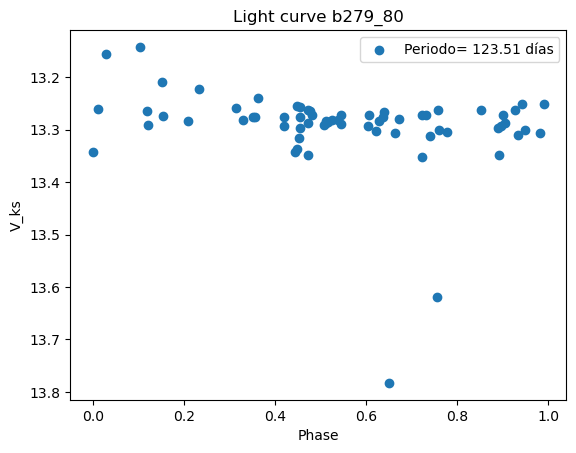

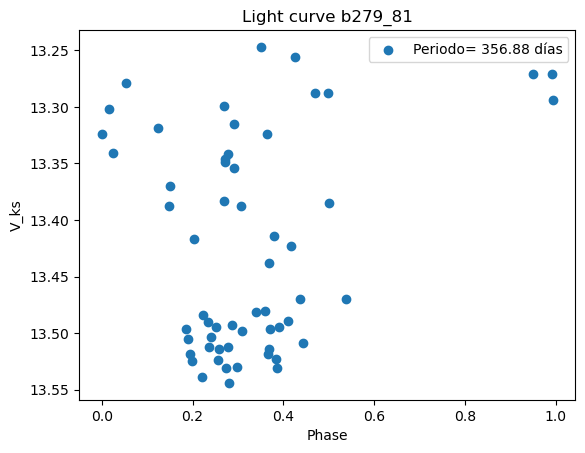

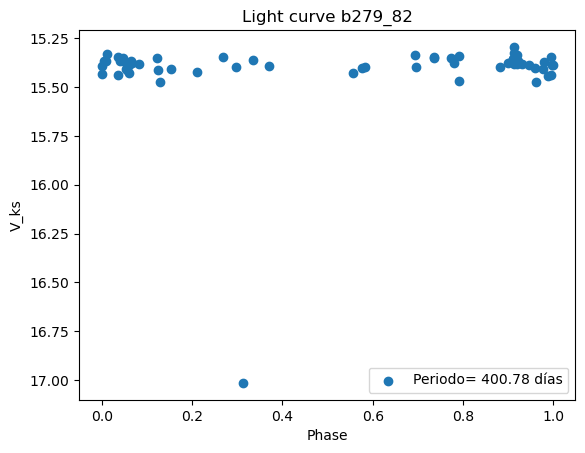

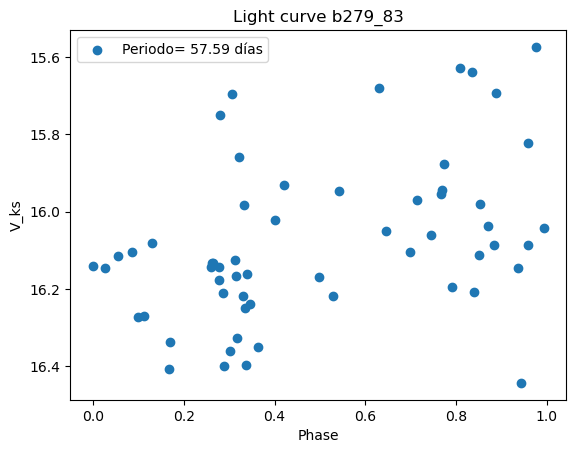

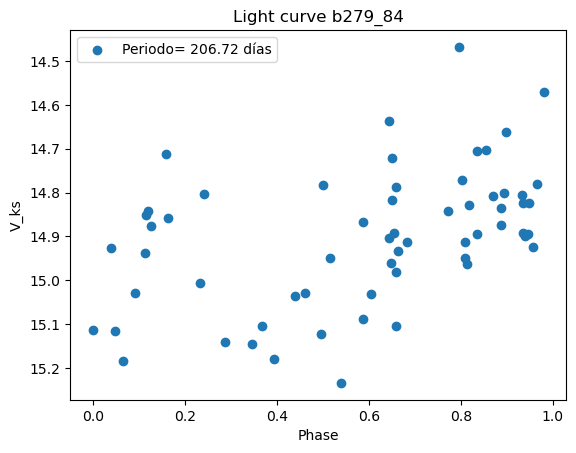

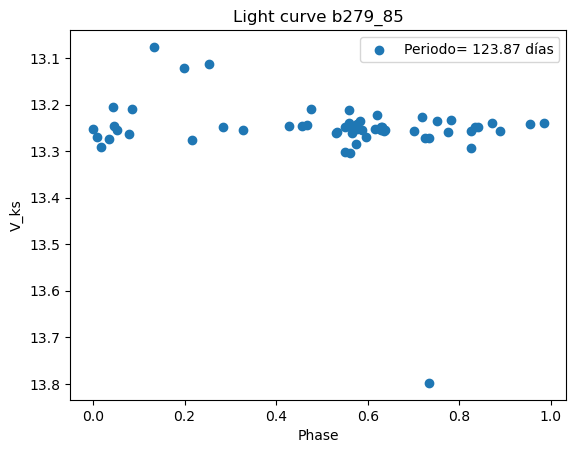

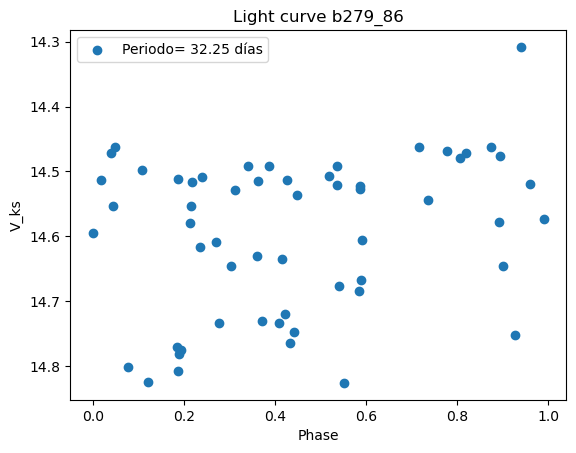

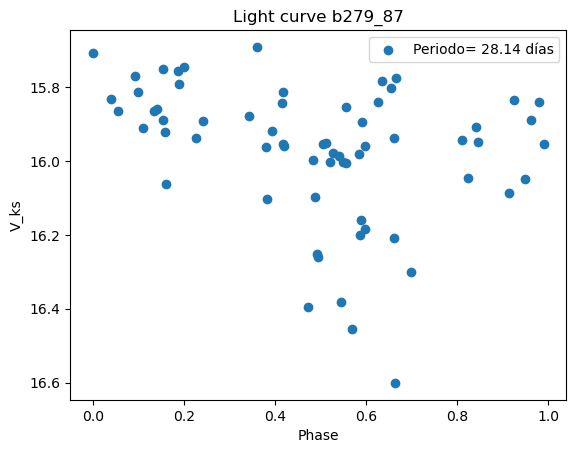

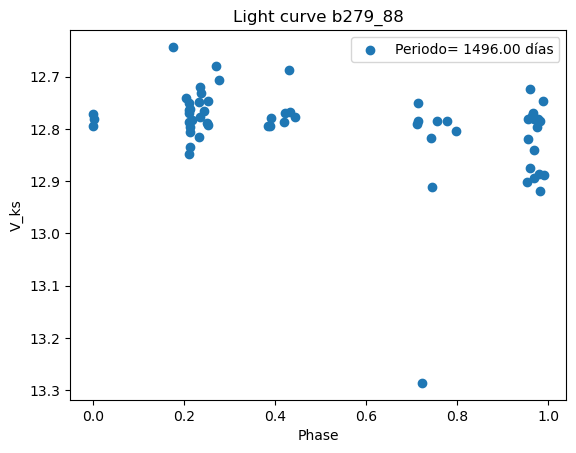

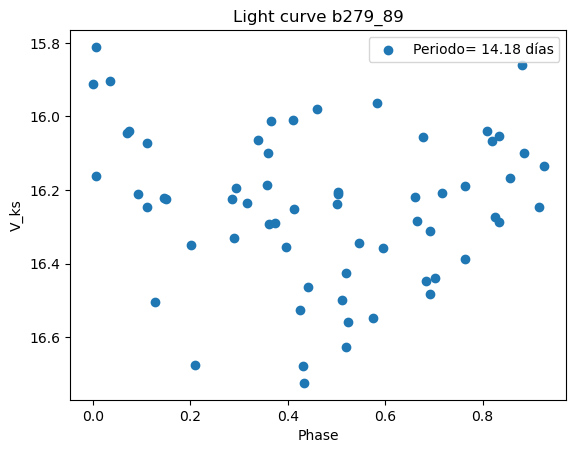

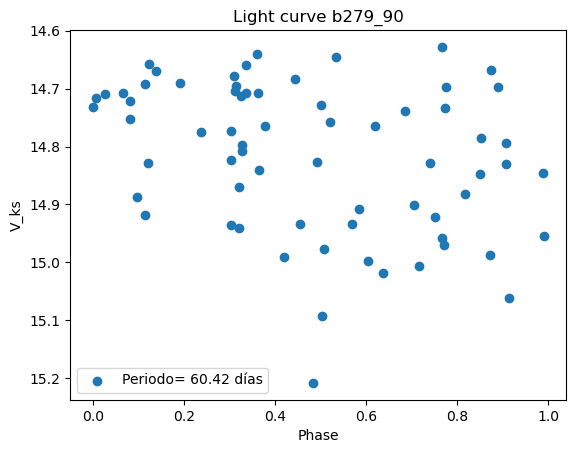

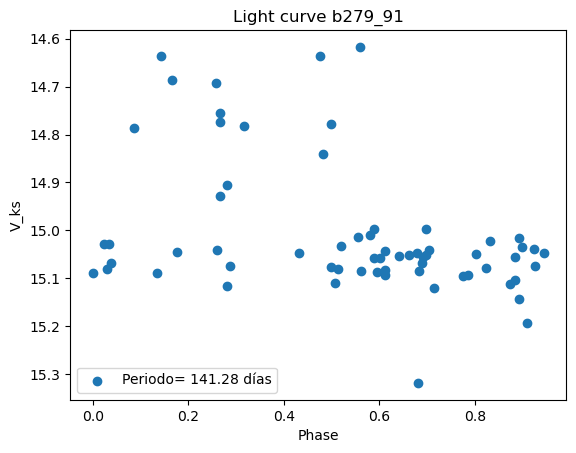

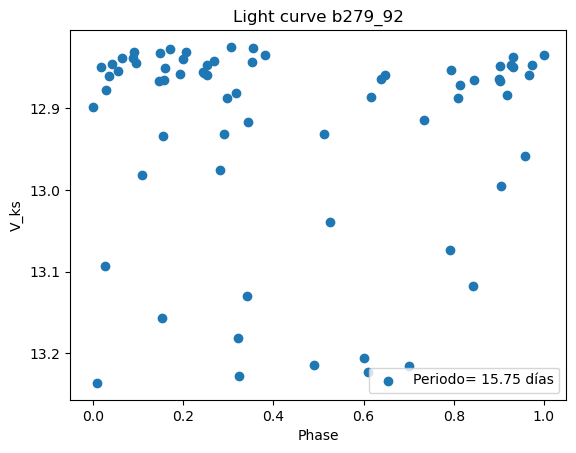

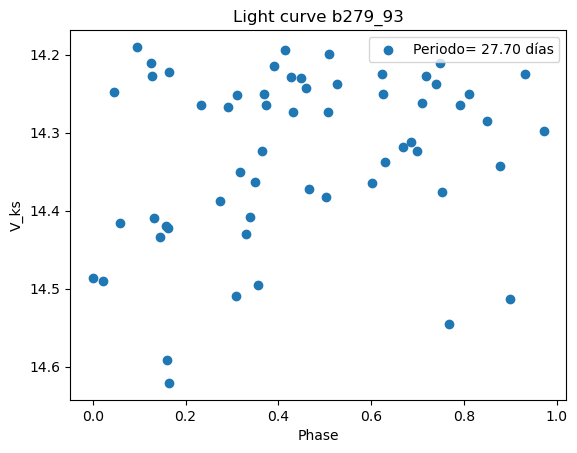

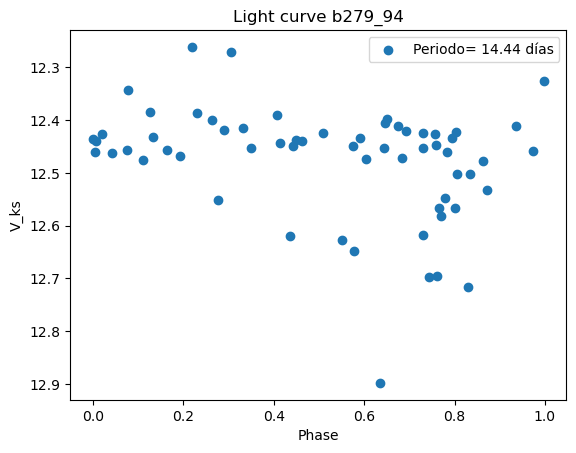

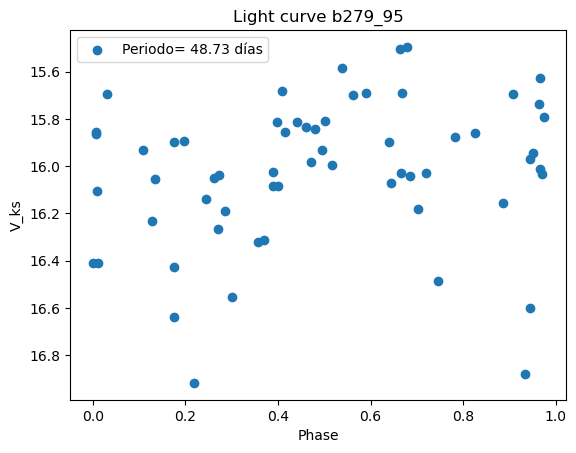

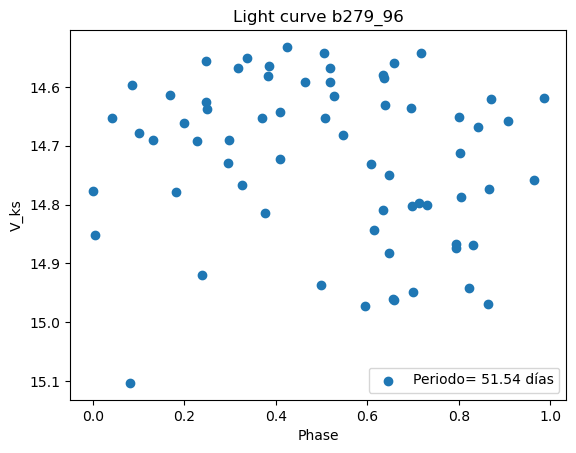

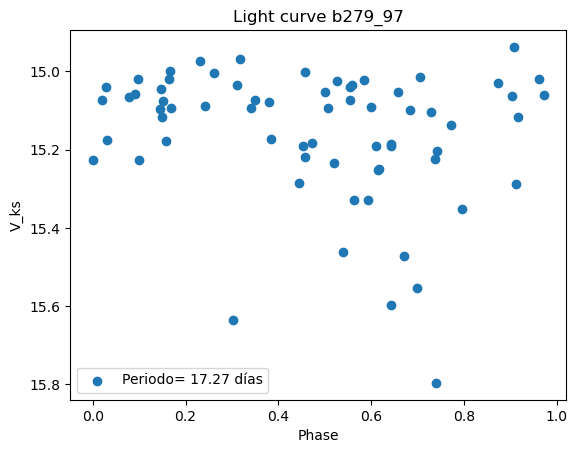

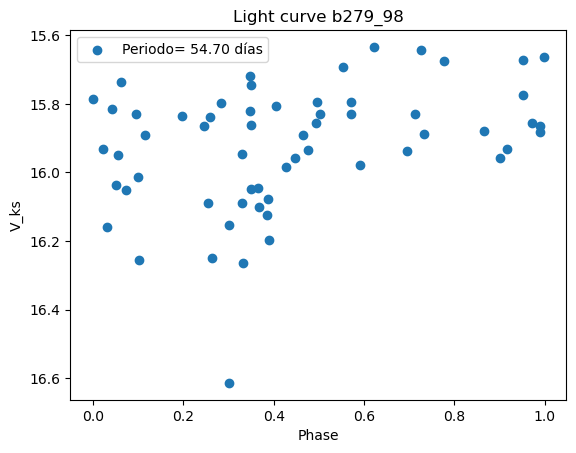

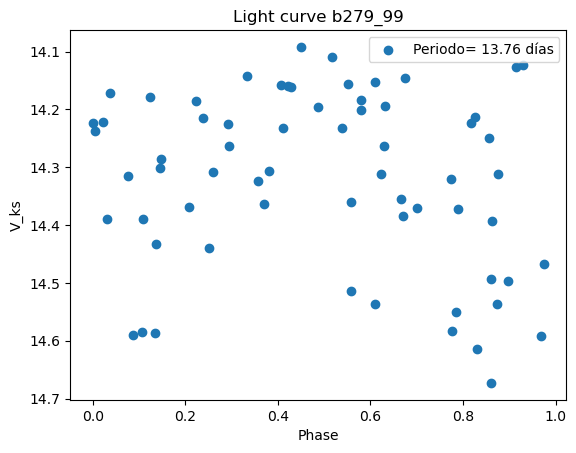

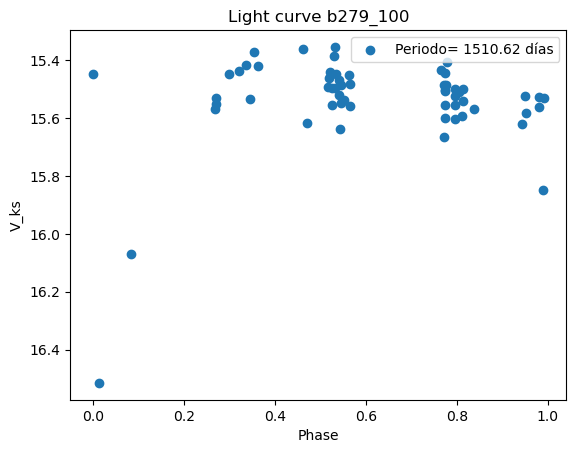

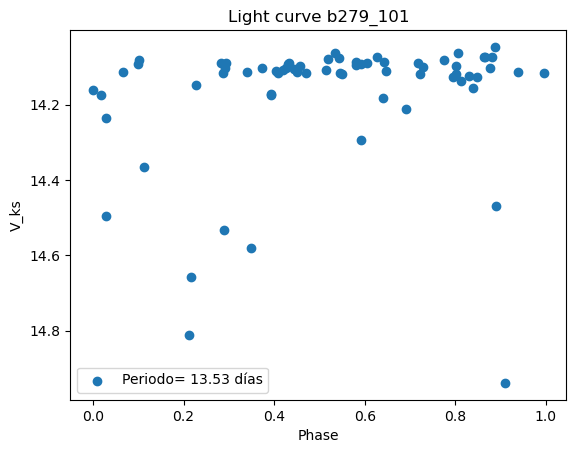

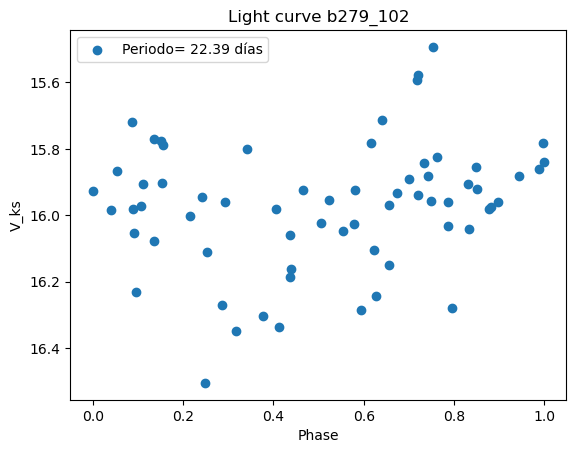

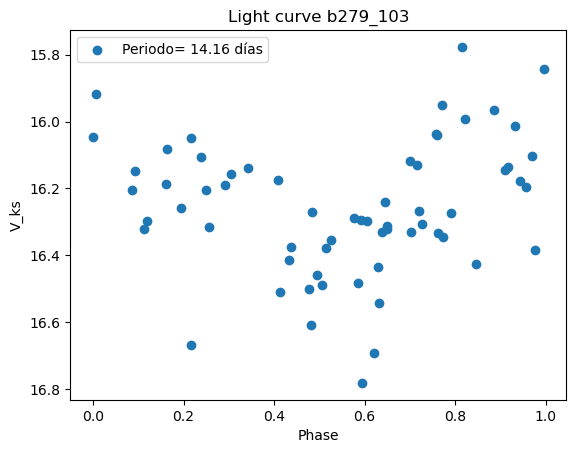

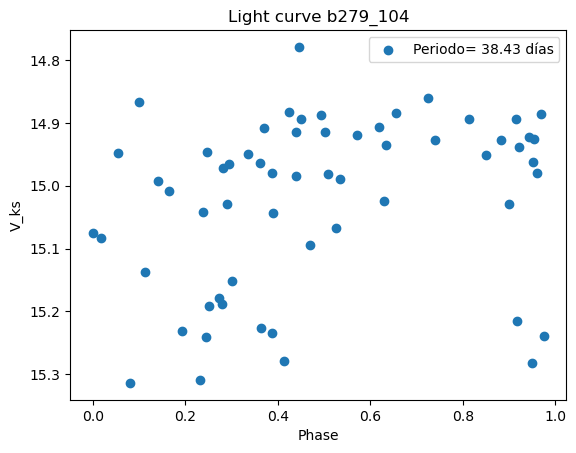

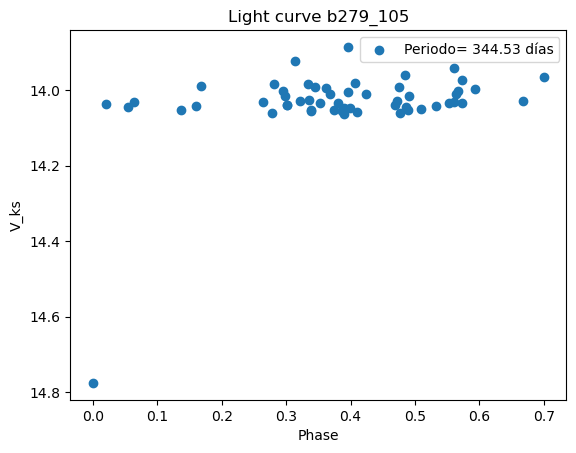

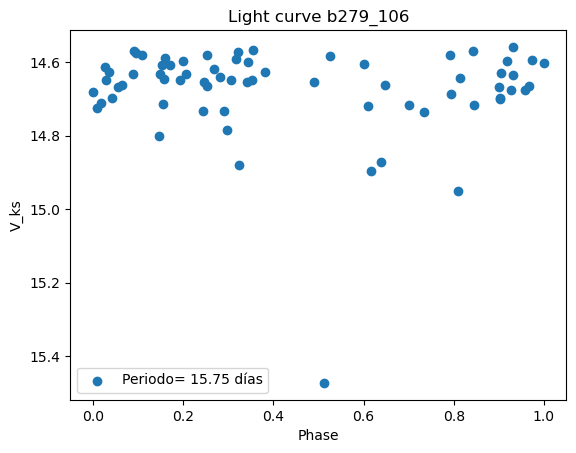

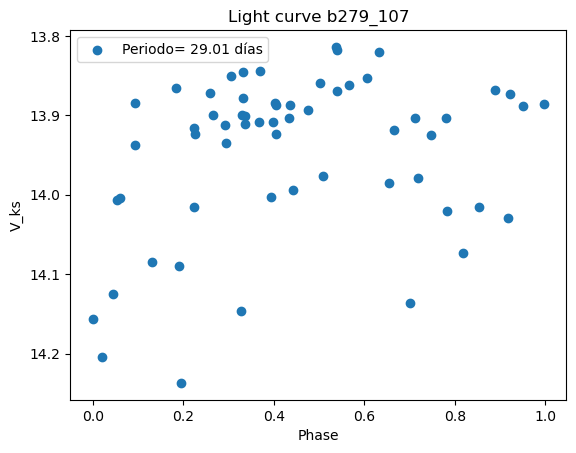

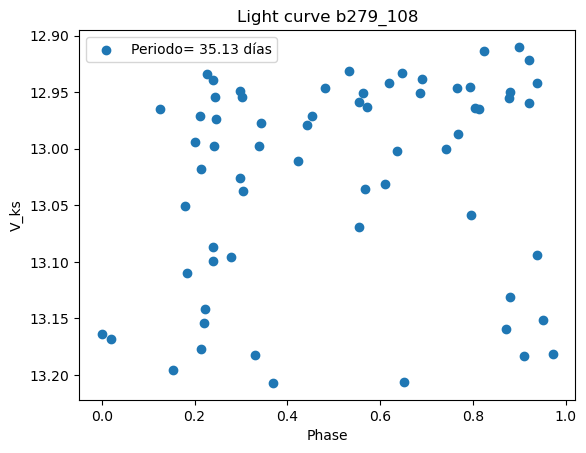

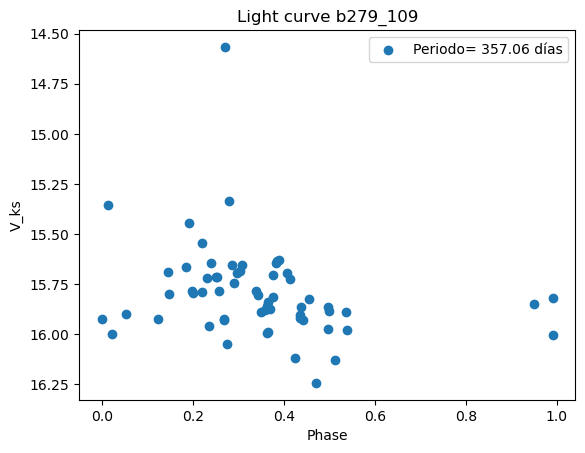

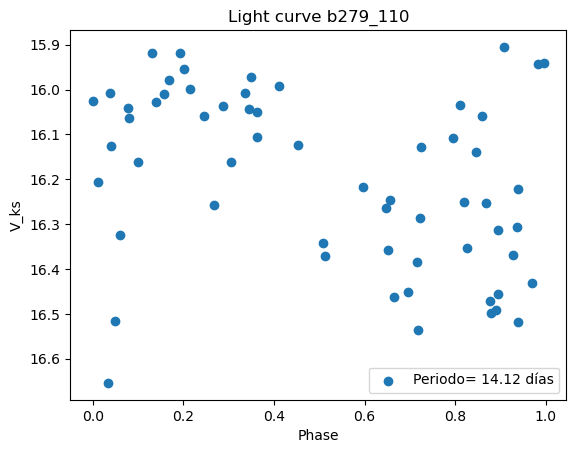

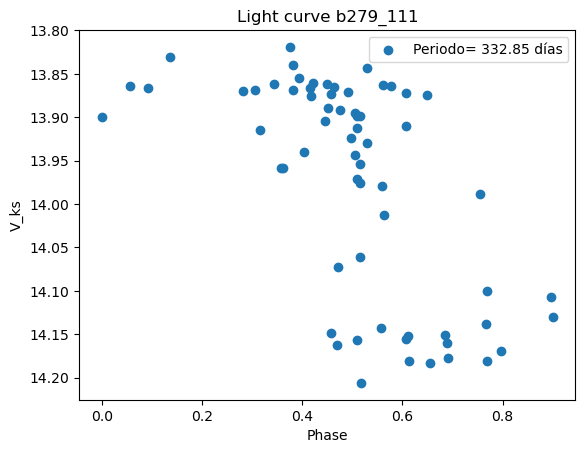

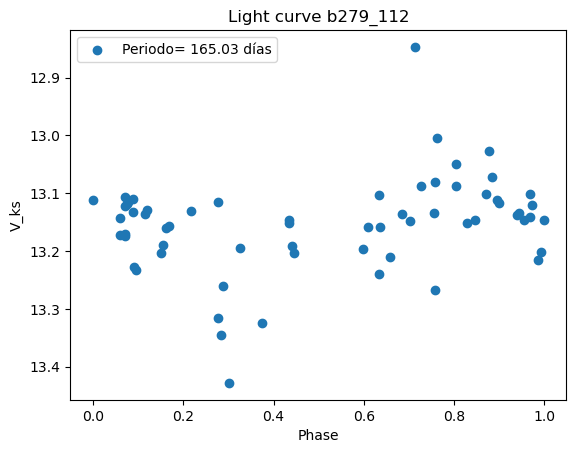

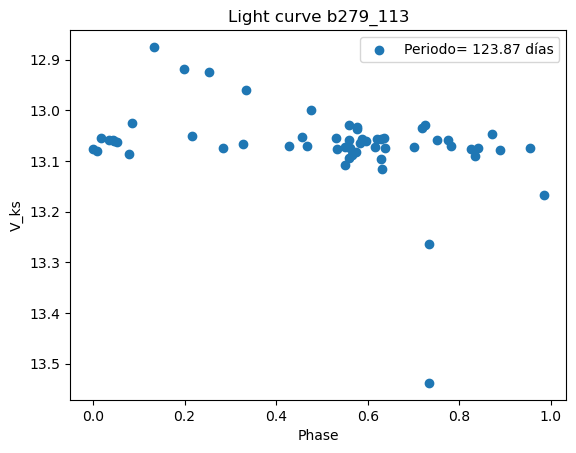

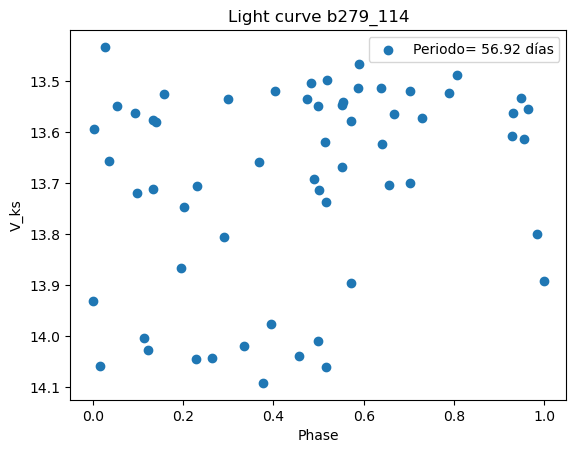

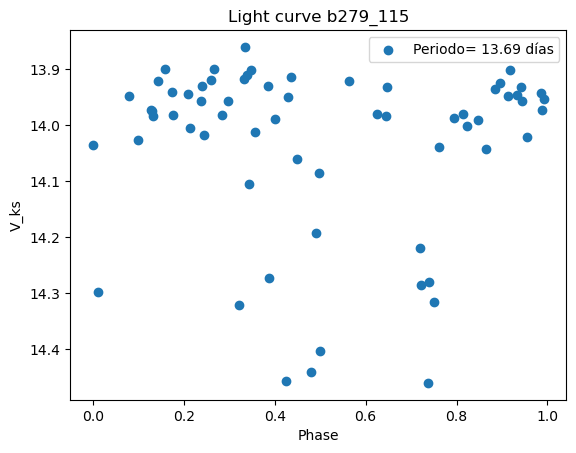

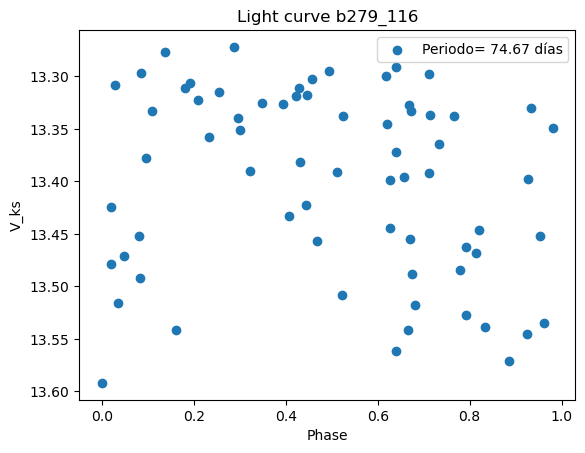

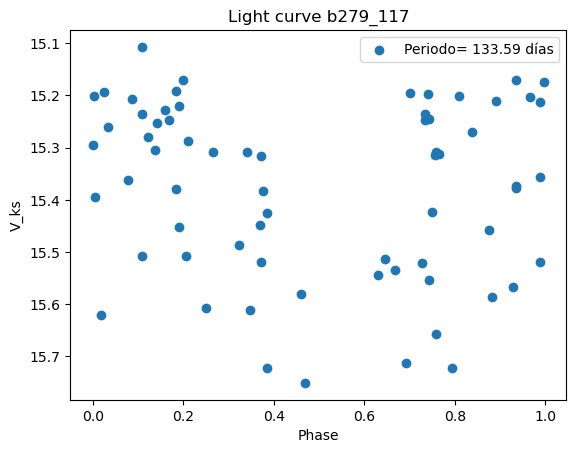

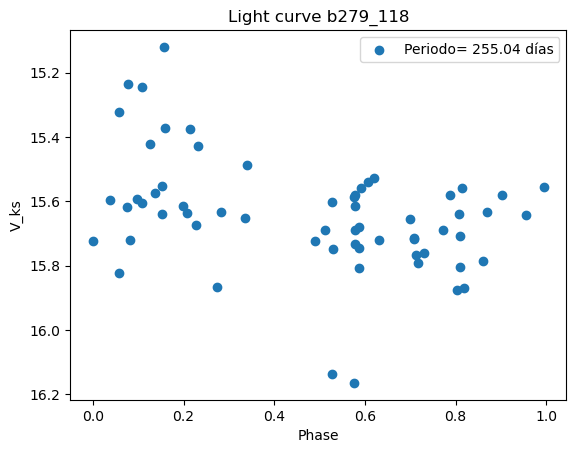

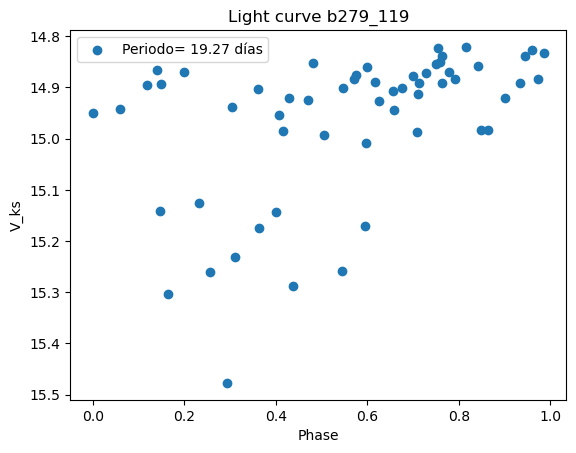

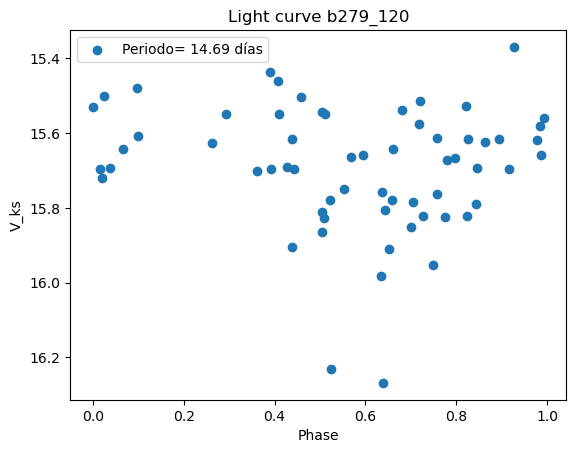

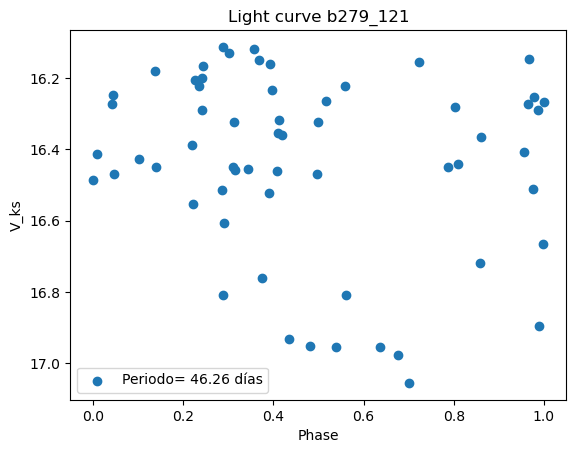

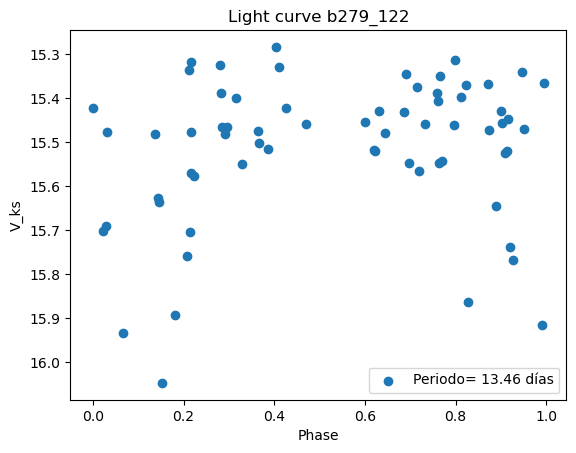

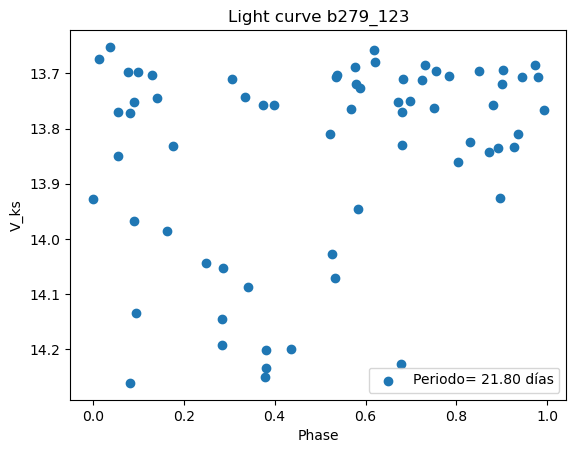

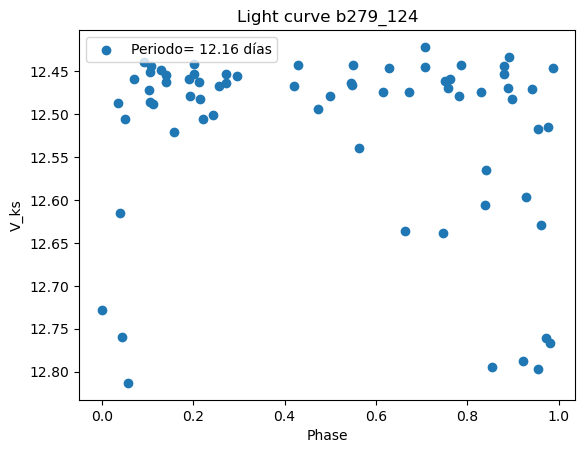

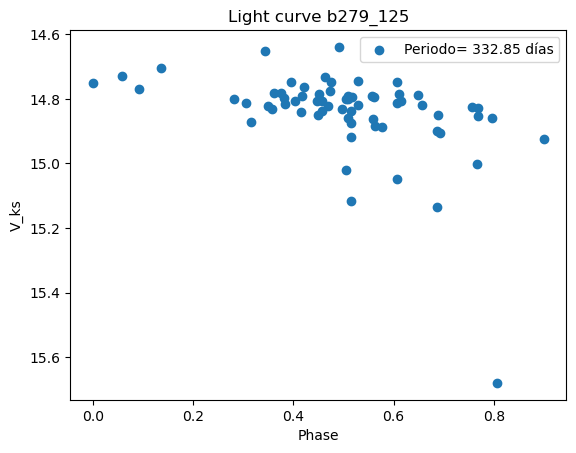

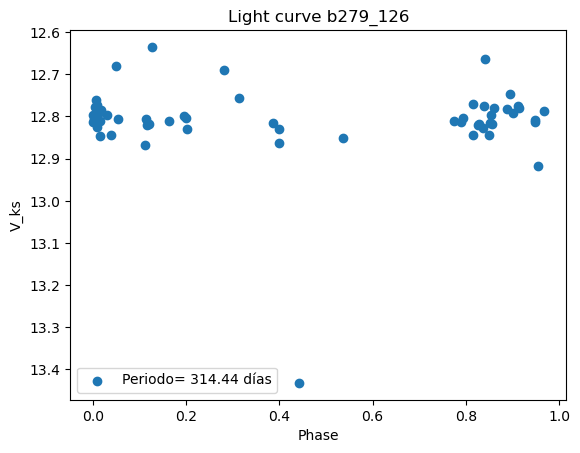

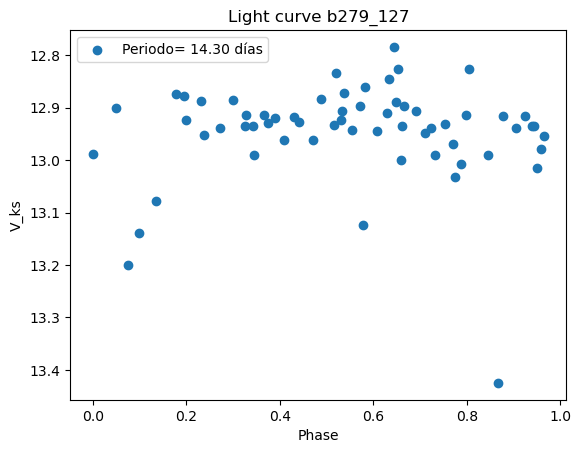

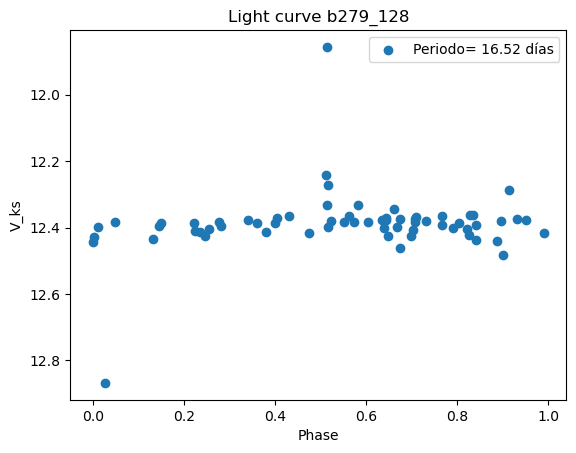

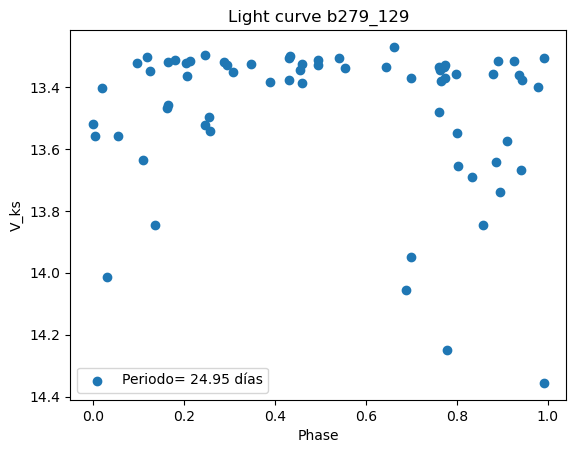

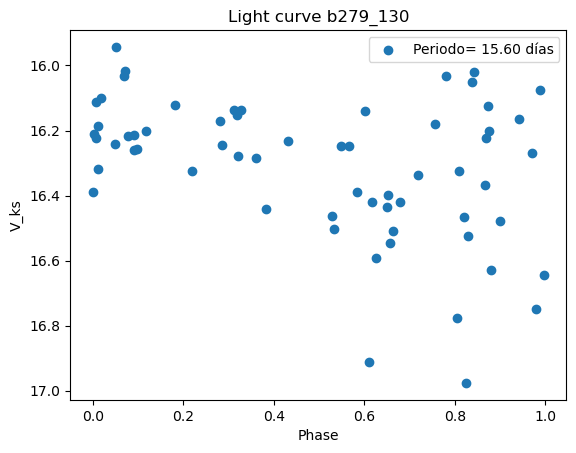

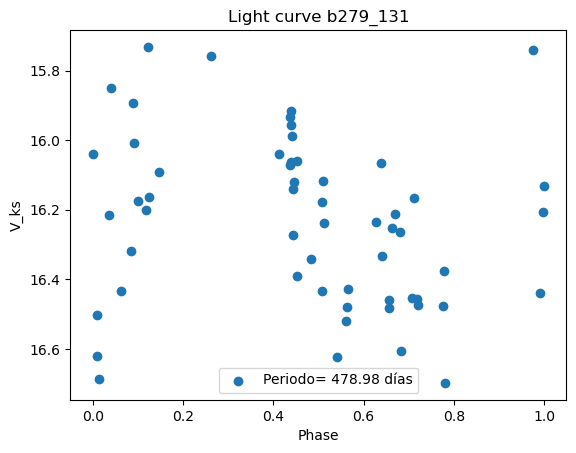

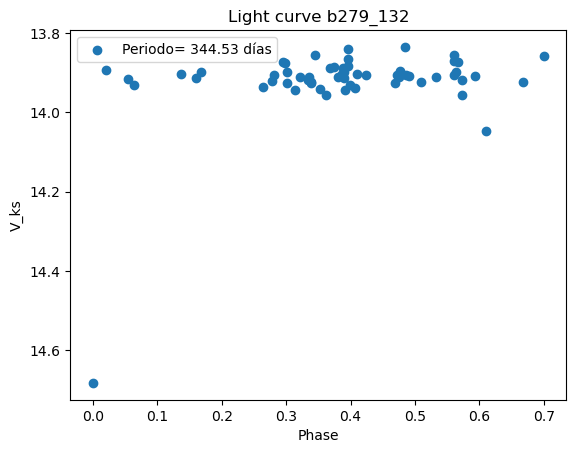

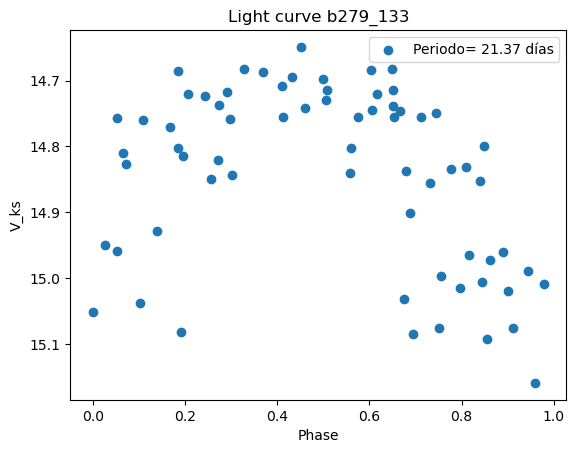

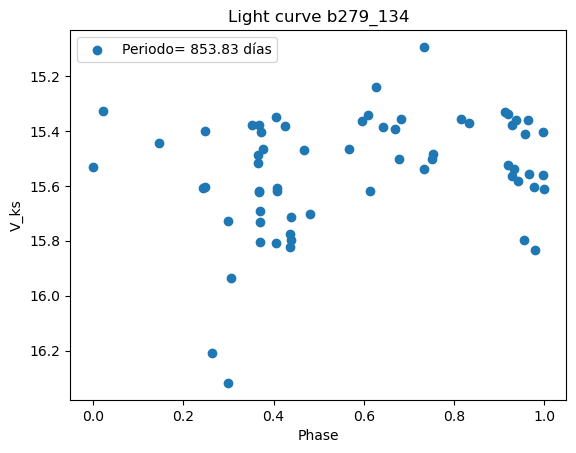

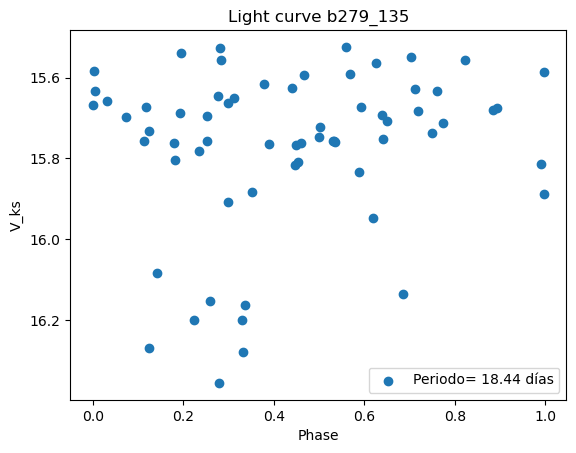

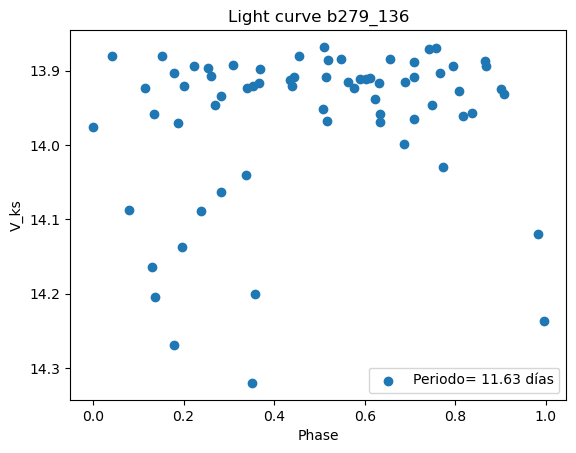

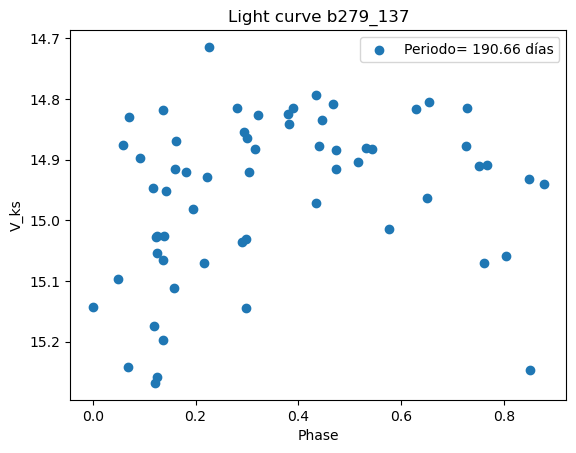

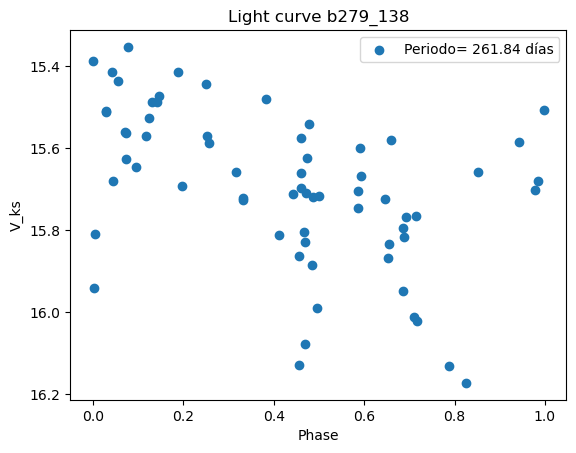

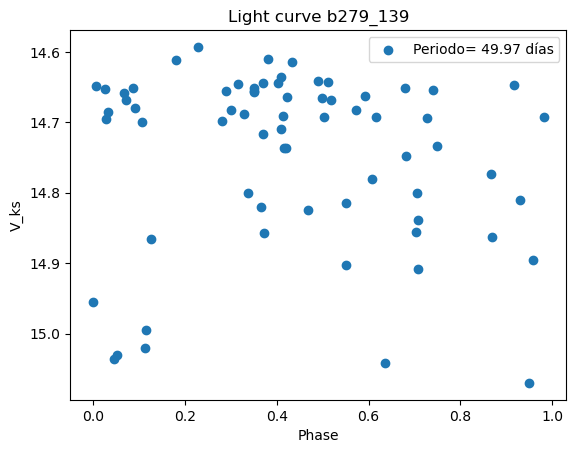

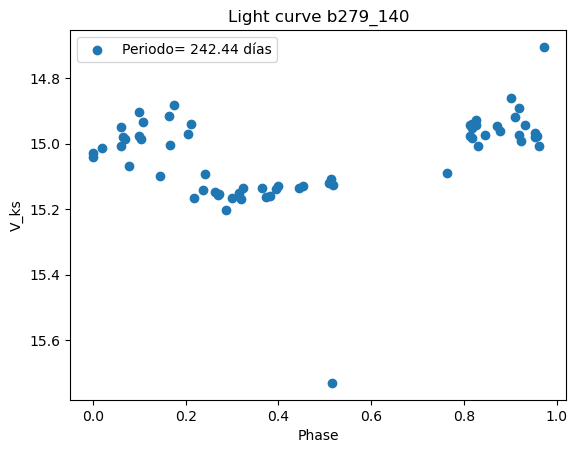

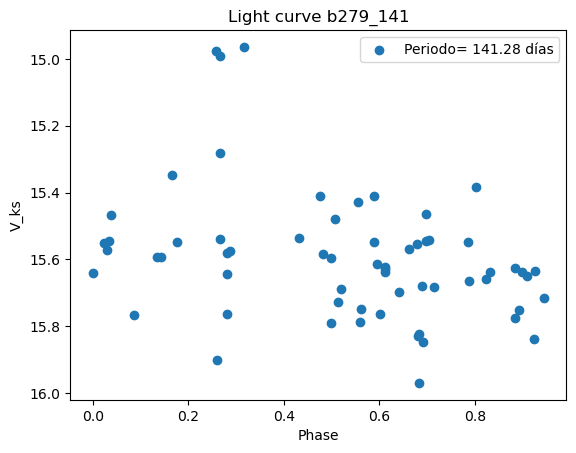

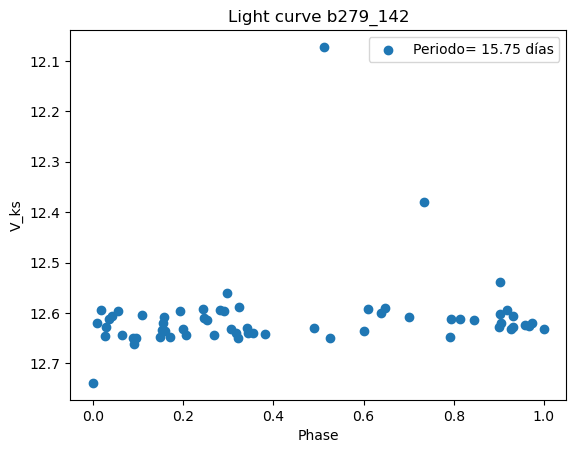

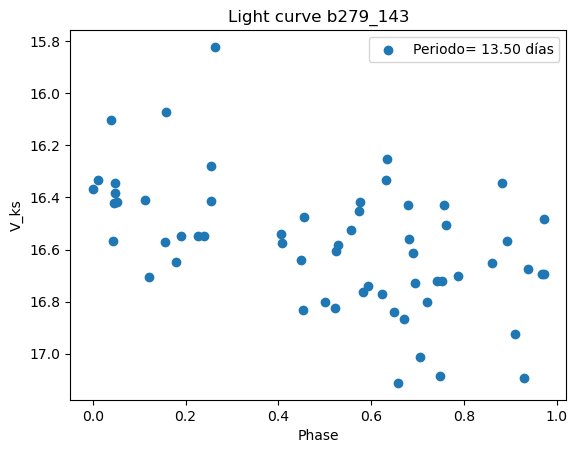

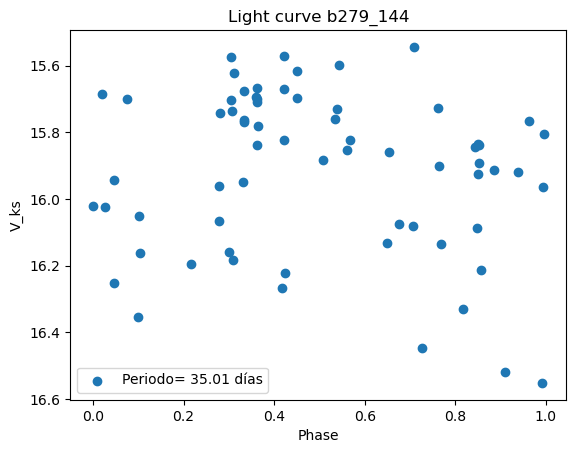

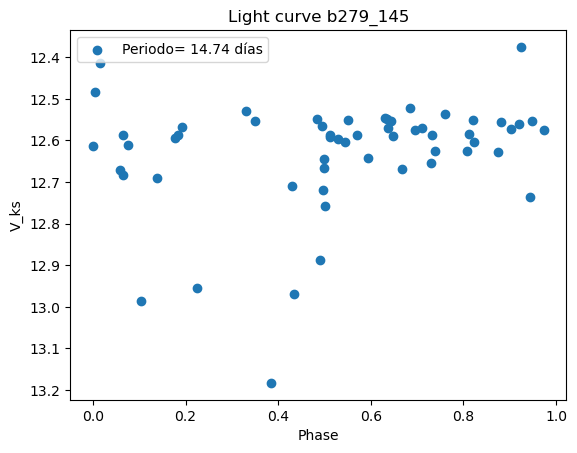

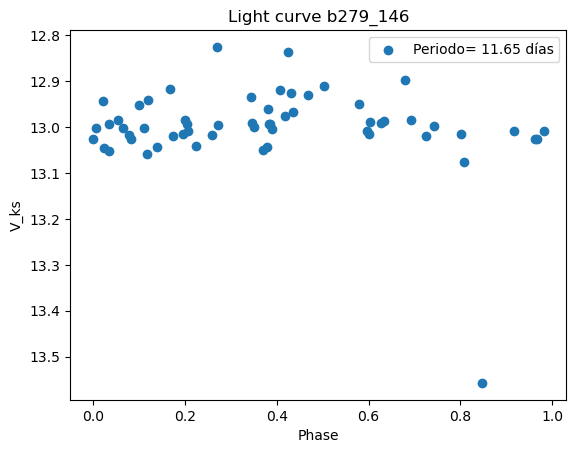

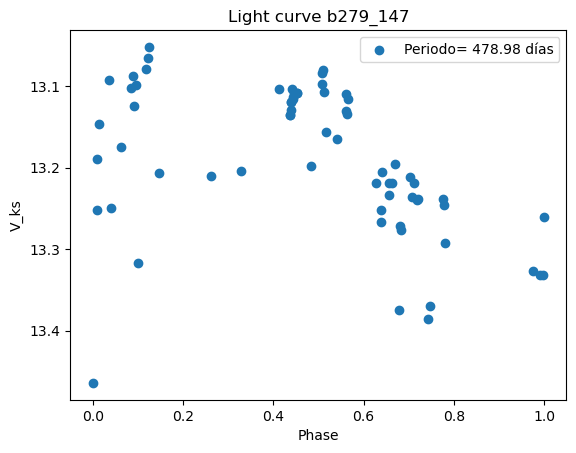

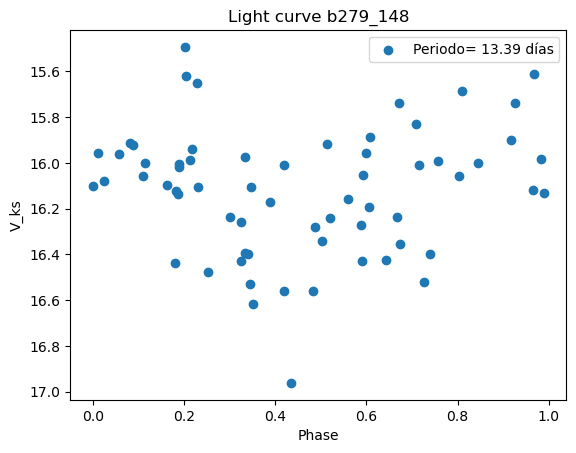

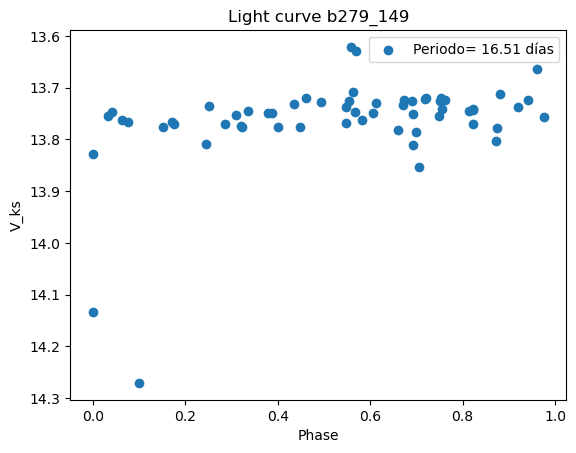

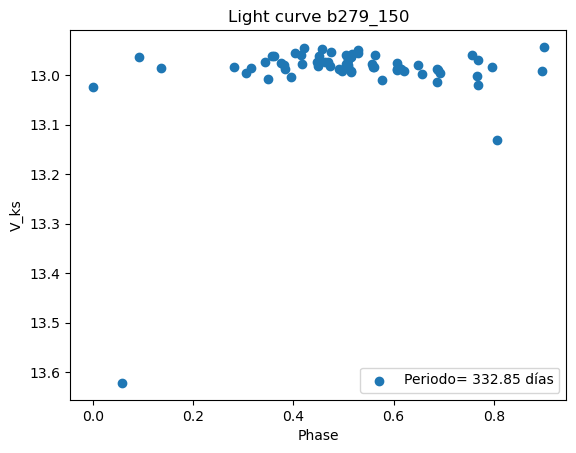

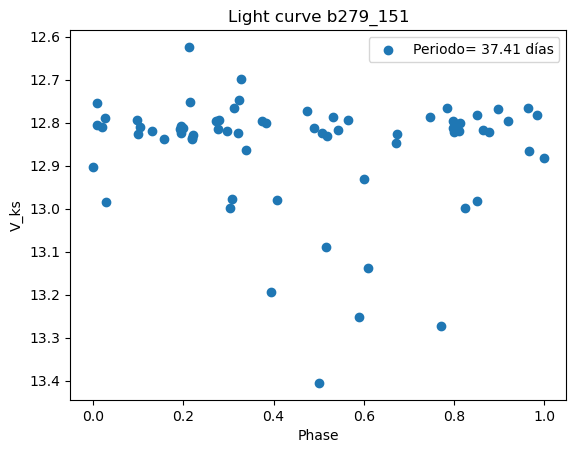

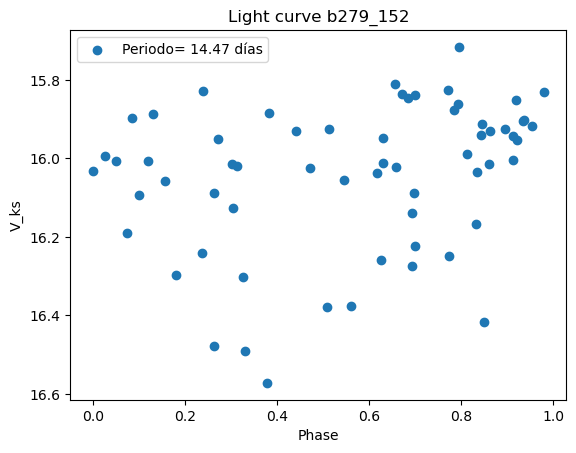

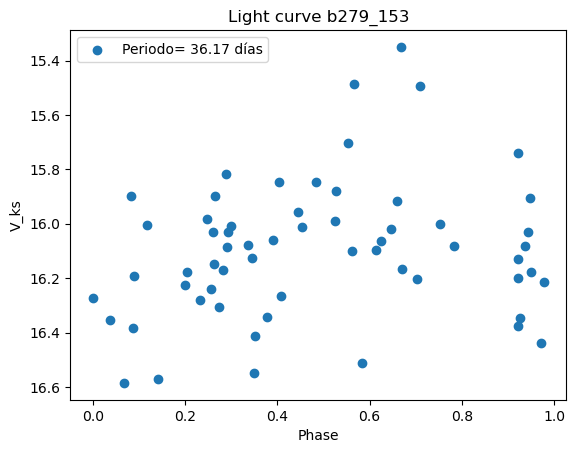

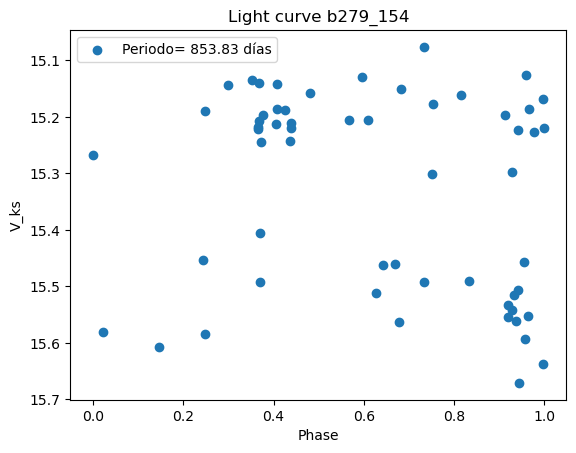

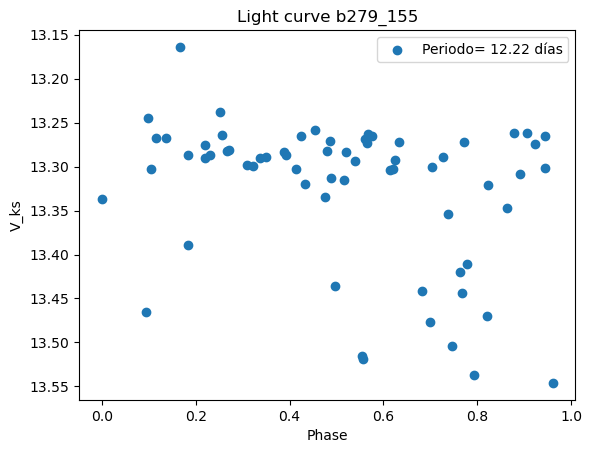

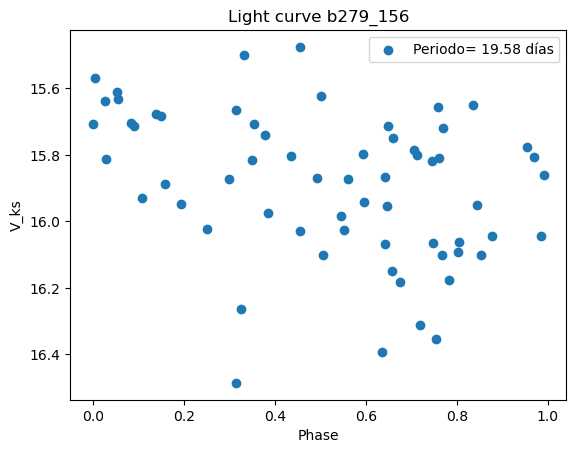

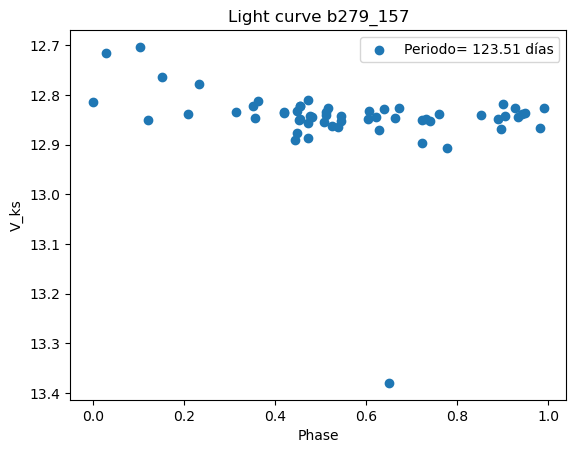

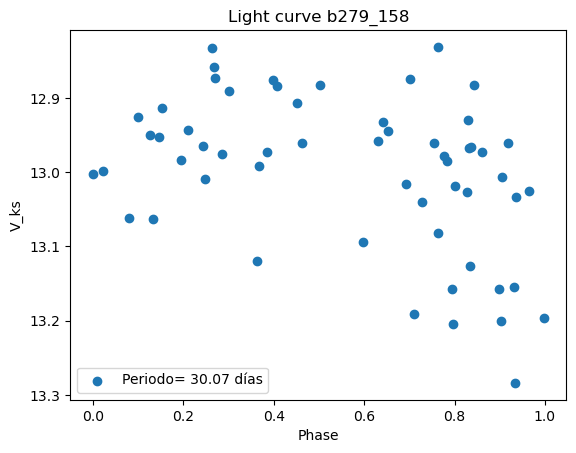

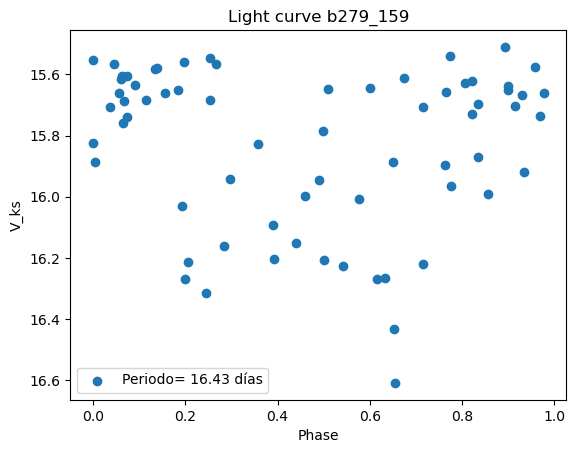

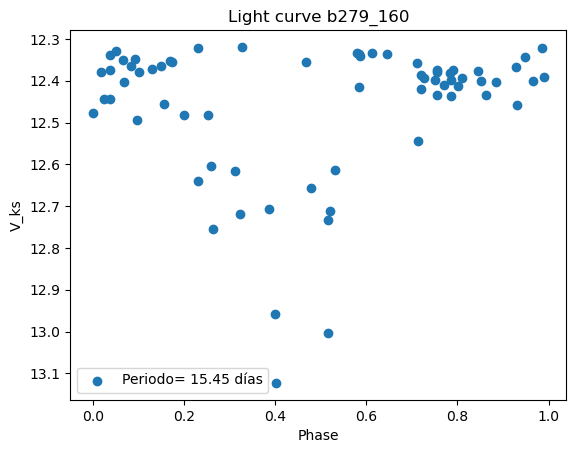

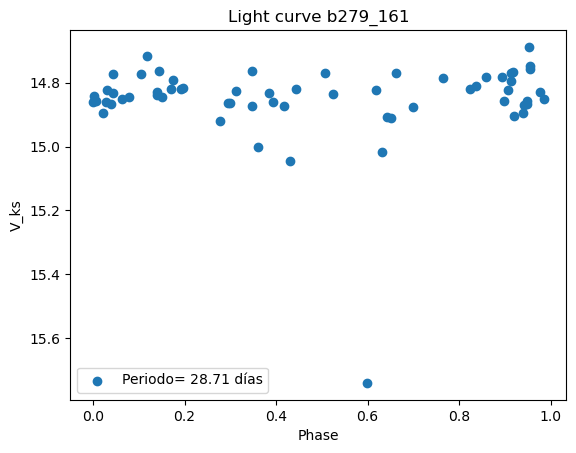

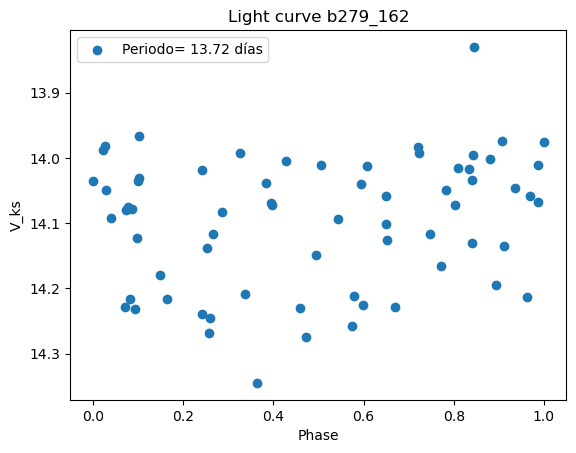

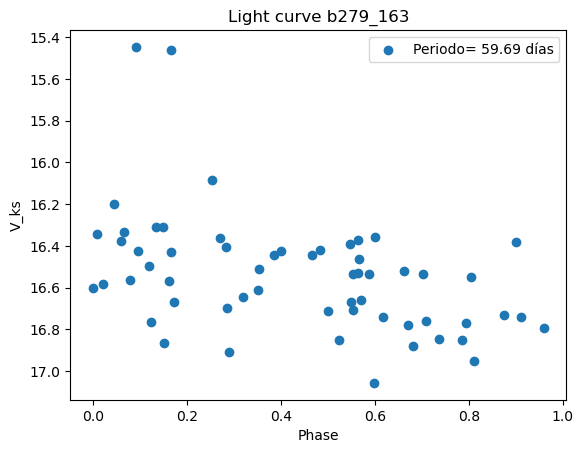

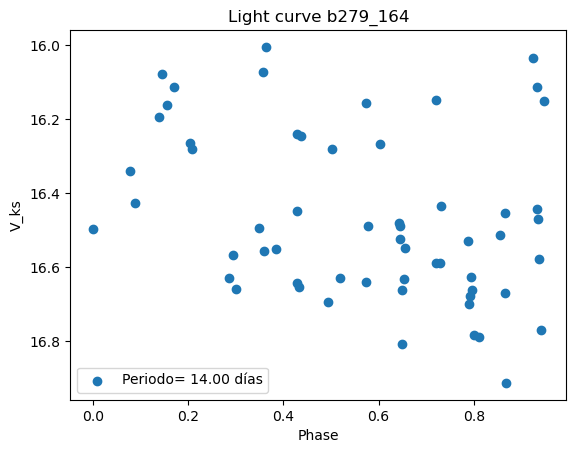

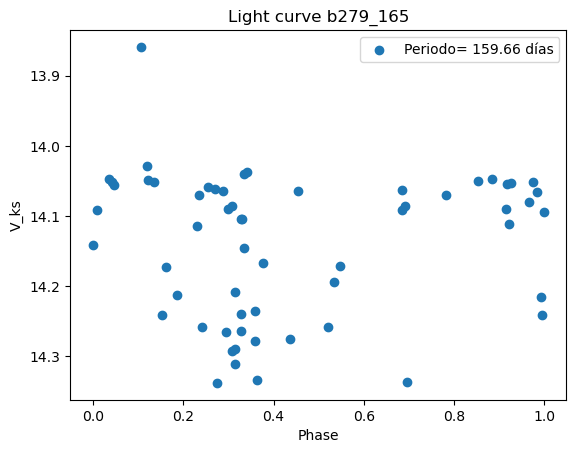

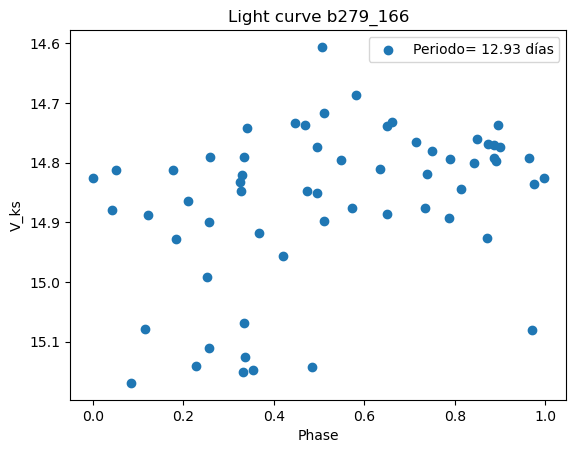

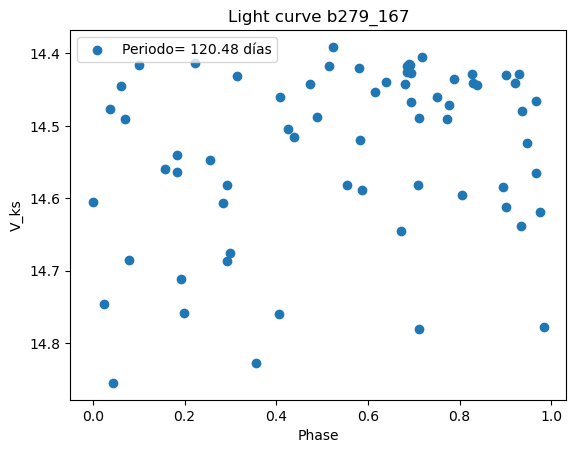

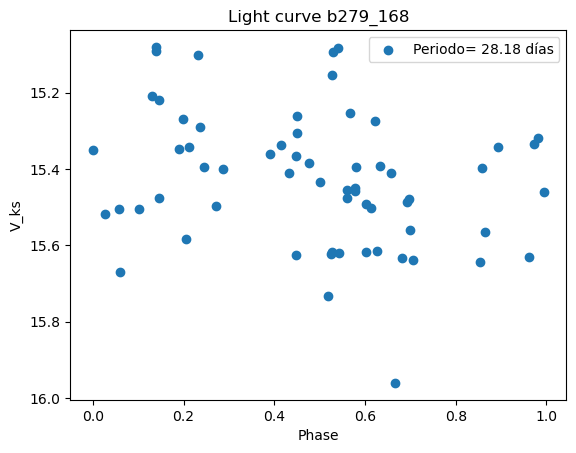

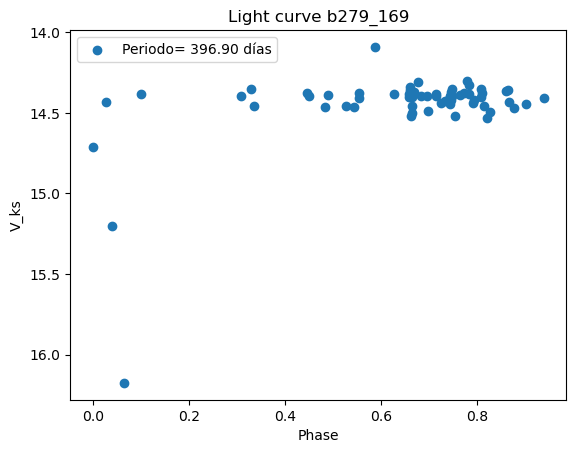

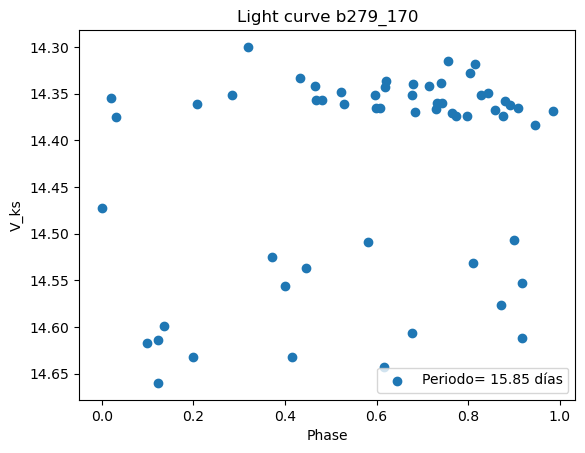

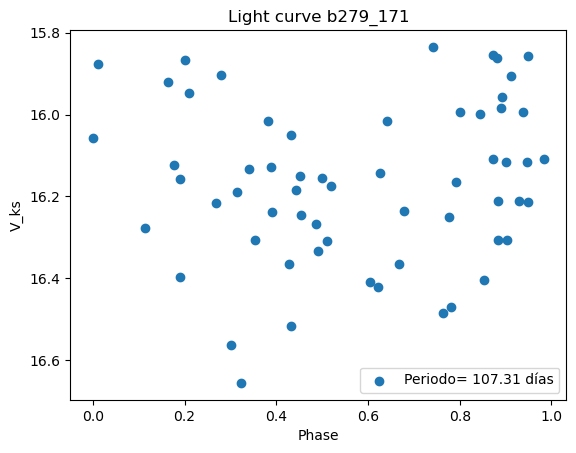

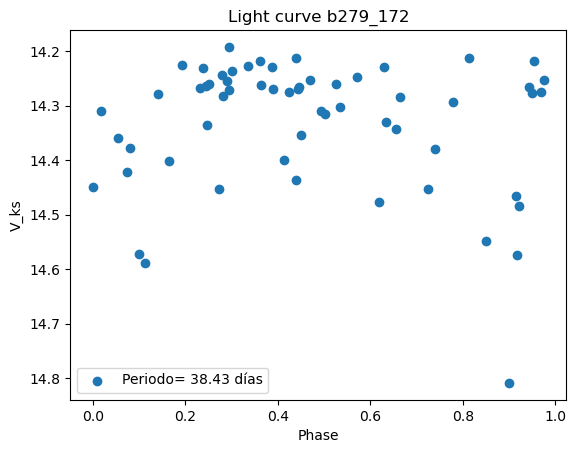

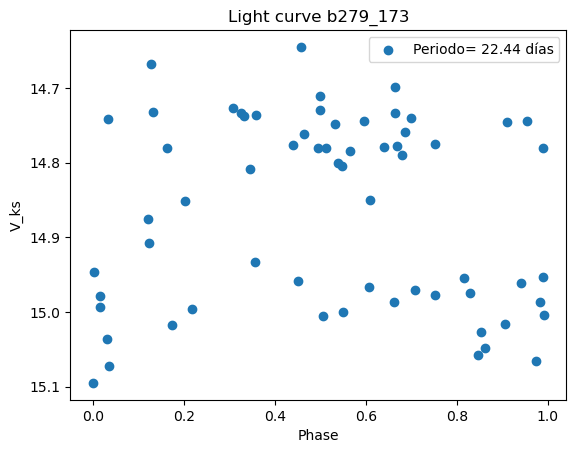

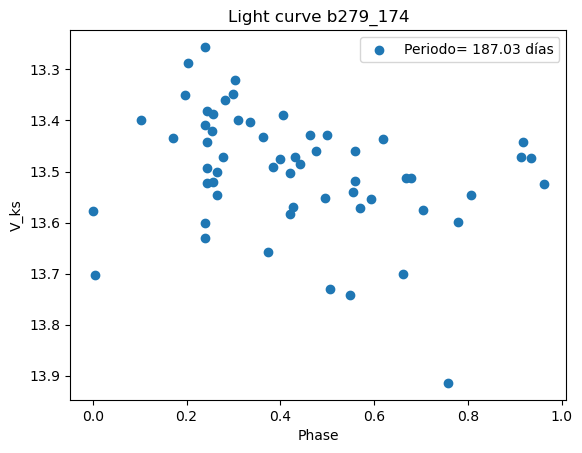

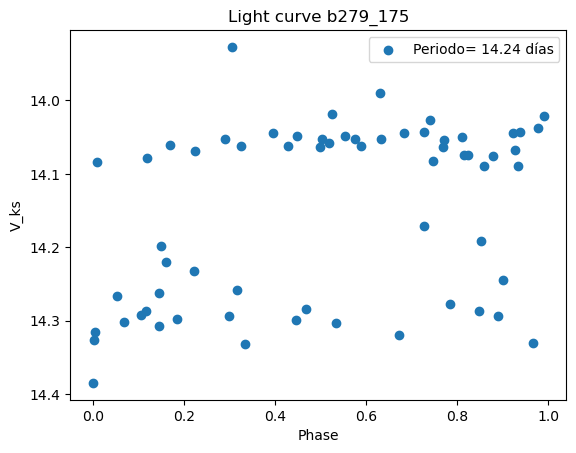

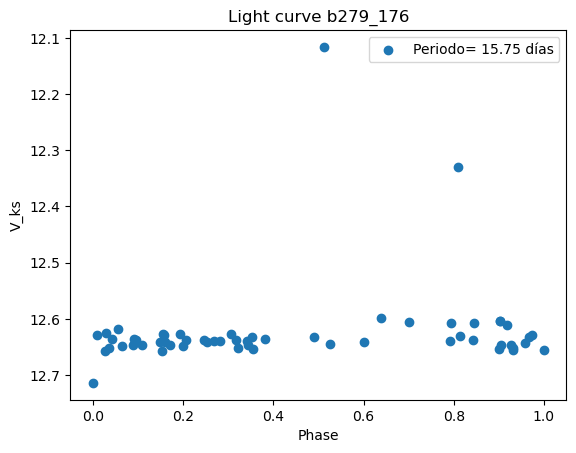

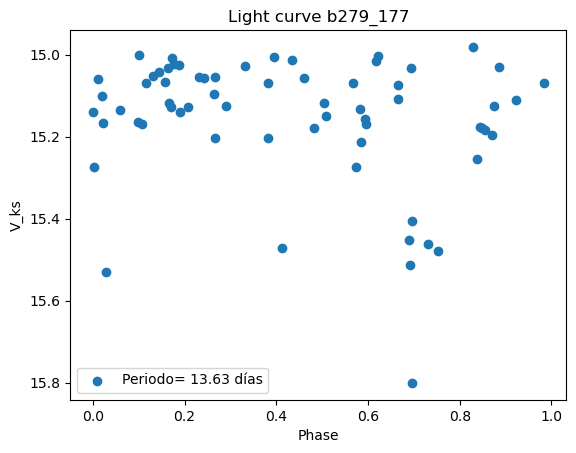

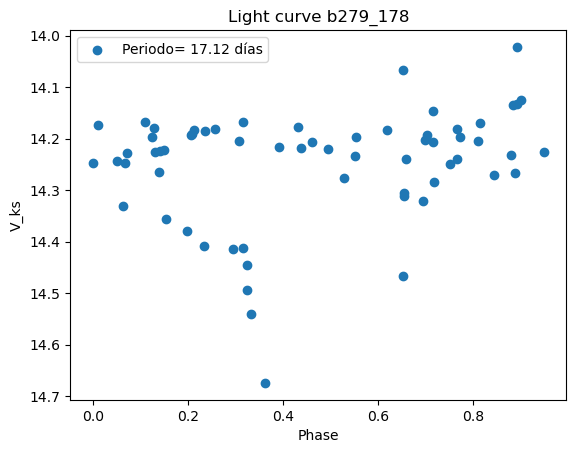

In [32]:
z=0
while z<len(ks_nan):
    S=ks_nan[z]
    Date=HJD_na[z]
    # Calcular el espectro de potencia utilizando Lomb-Scargle
    frequency, power = LombScargle(Date, S).autopower()
    # Encontrar picos en el espectro de potencia
    peaks, _ = find_peaks(power)
    # Obtener los 5 picos más significativos
    sorted_peaks = sorted(peaks, key=lambda x: power[x], reverse=True)[:5]
    frecuencia, potencia= frequency[sorted_peaks], list(power[sorted_peaks])
    max_p=max(potencia)
    r = potencia.index(max_p)
    f=frecuencia[r]
    P=1/f
    t_0 = Date[0]
    # 3. Calcular la fase para cada punto de tus datos
    fase = ((Date - t_0) / P) - np.floor((Date - t_0) / P)
    plt.scatter(fase, S)
    plt.xlabel('Phase')
    plt.ylabel('V_ks')
    # Invertir el eje y
    plt.gca().invert_yaxis()
    plt.title('Light curve b279_'+ str(z))
    # Muestra la leyenda con el período promedio
    plt.legend(['Periodo= {:.2f} días'.format(P)])
    # Guarda la gráfica en un archivo
    #plt.savefig('Curva3_b279.png')
    plt.show()
    z+=1

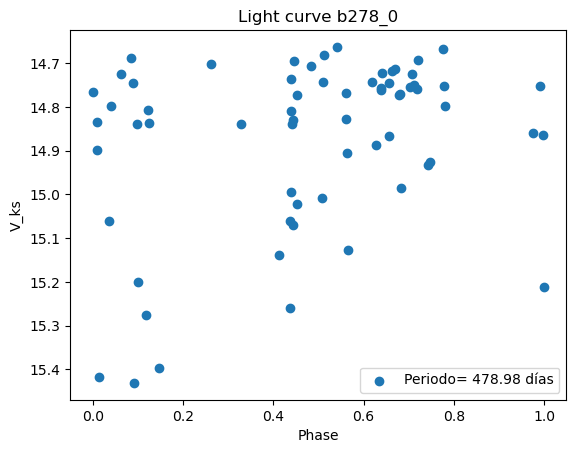

In [5]:
S=ks_nan[0]
Date=HJD_na[0]
# Calcular el espectro de potencia utilizando Lomb-Scargle
frequency, power = LombScargle(Date, S).autopower()
# Encontrar picos en el espectro de potencia
peaks, _ = find_peaks(power)
# Obtener los 5 picos más significativos
sorted_peaks = sorted(peaks, key=lambda x: power[x], reverse=True)[:5]
frecuencia, potencia= frequency[sorted_peaks], list(power[sorted_peaks])
max_p=max(potencia)
r = potencia.index(max_p)
f=frecuencia[r]
P=1/f
t_0 = Date[0]
# 3. Calcular la fase para cada punto de tus datos
fase = ((Date - t_0) / P) - np.floor((Date - t_0) / P)
plt.scatter(fase, S)
plt.xlabel('Phase')
plt.ylabel('V_ks')
# Invertir el eje y
plt.gca().invert_yaxis()
plt.title('Light curve b278_0')
# Muestra la leyenda con el período promedio
plt.legend(['Periodo= {:.2f} días'.format(P)])
# Guarda la gráfica en un archivo
#plt.savefig('Curva3_b279.png')
plt.show()

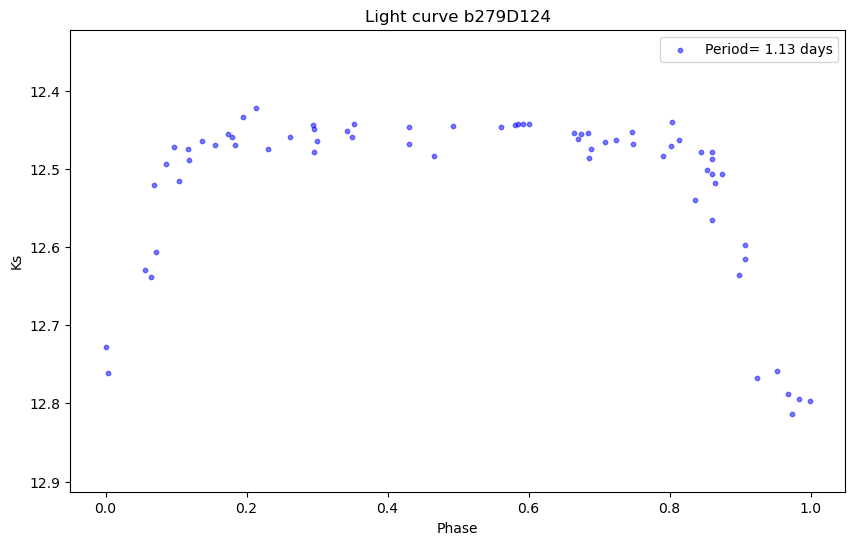

In [30]:
# Define tus datos de magnitud y fecha
S = ks_nan[124]
Date = HJD_na[124]

# Calcular el espectro de potencia utilizando Lomb-Scargle
frequency, power = LombScargle(Date, S).autopower()

# Encontrar picos en el espectro de potencia
peaks, _ = find_peaks(power)

# Obtener los 5 picos más significativos
sorted_peaks = sorted(peaks, key=lambda x: power[x], reverse=True)[:5]
frecuencia, potencia = frequency[sorted_peaks], list(power[sorted_peaks])
max_p = max(potencia)
r = potencia.index(max_p)
f = frecuencia[r]
P = 1.128431
# Calcular la fase para cada punto de tus datos
t_0 = Date[0]
fase = ((Date - t_0) / P)% 1

# Graficar la curva de luz
plt.figure(figsize=(10, 6))
plt.scatter(fase, S, s=10, c='blue', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Ks')
plt.gca().invert_yaxis()
plt.ylim(max(S)+0.1, min(S)-0.1)  # Ajustar la escala del eje y
plt.title('Light curve b279D124')
plt.legend(['Period= {:.2f} days'.format(P)])
plt.show()

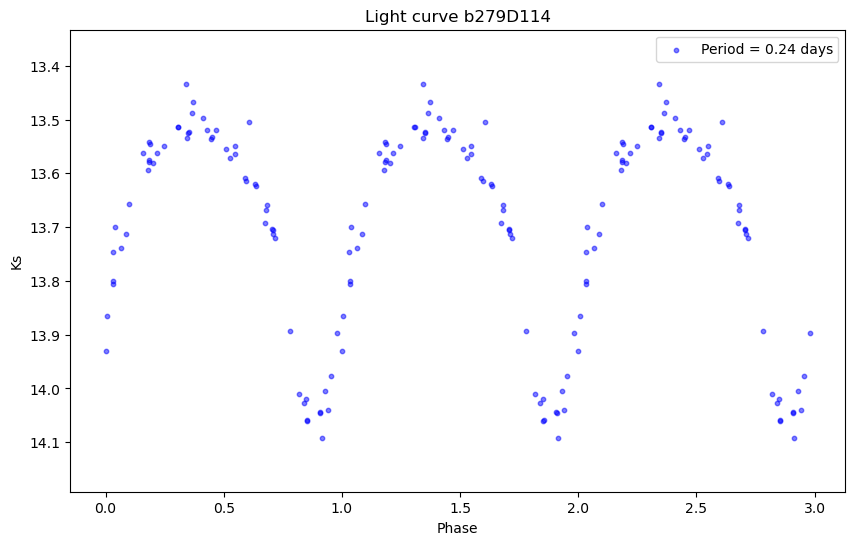

In [35]:
# Define tus datos de magnitud y fecha
S = ks_nan[114]
Date = HJD_na[114]

# Calcular el espectro de potencia utilizando Lomb-Scargle
frequency, power = LombScargle(Date, S).autopower()

# Encontrar picos en el espectro de potencia
peaks, _ = find_peaks(power)

# Obtener los 5 picos más significativos
sorted_peaks = sorted(peaks, key=lambda x: power[x], reverse=True)[:5]
frecuencia, potencia = frequency[sorted_peaks], list(power[sorted_peaks])
max_p = max(potencia)
r = potencia.index(max_p)
f = frecuencia[r]
P = 0.237901
# Calcular la fase para cada punto de tus datos
t_0 = Date[0]
fase = ((Date - t_0) / P)% 1

# Graficar la curva de luz
plt.figure(figsize=(10, 6))
plt.scatter(fase, S, s=10, c='blue', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Ks')
plt.gca().invert_yaxis()
plt.ylim(max(S)+0.1, min(S)-0.1)  # Ajustar la escala del eje y
plt.title('Light curve b279D114')
plt.legend(['Period = {:.2f} days'.format(P)])
# Graficar otro ciclo (por ejemplo, sumando el período a la fase)
plt.scatter(fase + 1, S, s=10, c='blue', alpha=0.5)
plt.scatter(fase + 2, S, s=10, c='blue', alpha=0.5)
plt.savefig('Light curve b279D114')
plt.show()

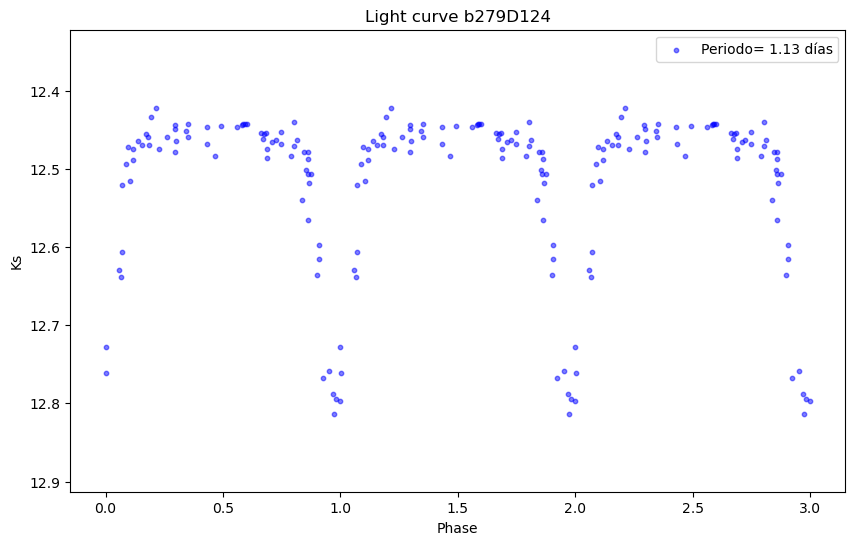

In [38]:
# Define tus datos de magnitud y fecha
S = ks_nan[124]
Date = HJD_na[124]
# Periodo
P = 1.128431

# Calcular la fase para cada punto de tus datos
t_0 = Date[0]
fase = ((Date - t_0) / P) % 1

# Graficar la curva de luz
plt.figure(figsize=(10, 6))
plt.scatter(fase, S, s=10, c='blue', alpha=0.5)
plt.xlabel('Phase')
plt.ylabel('Ks')
plt.gca().invert_yaxis()
plt.ylim(max(S)+0.1, min(S)-0.1)  # Ajustar la escala del eje y
plt.title('Light curve b279D124')
plt.legend(['Periodo= {:.2f} días'.format(P)])

# Graficar otro ciclo (por ejemplo, sumando el período a la fase)
plt.scatter(fase + 1, S, s=10, c='blue', alpha=0.5)
plt.scatter(fase + 2, S, s=10, c='blue', alpha=0.5)
plt.savefig('Light curve b279D124')

plt.show()